### Import Python Libraries

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#used to import the zipfile and read it
import zipfile as zf
#used for working with various type of io streams
import io
# used for array processing
import numpy as np
# used to read the data into python pandas dataframe
import pandas as pd
# used for graphical plotting
import matplotlib.pyplot as plt
# used for graphical plotting
import seaborn as sns
# used to fill NAN values
from sklearn.impute import SimpleImputer
# used for oversampling the minority class
from imblearn.over_sampling import SMOTE
# used for undersampling the majority class
from imblearn.under_sampling import RandomUnderSampler
# used for building the pipeline for  oversampling and undersampling classifer data
from imblearn.pipeline import Pipeline
# used to scale the data for Principal Component Analysis
from sklearn.preprocessing import StandardScaler
# used for importing KMeans
from sklearn.cluster import KMeans
# used for importing Hieararchical Clustering
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
# used for importing Principal Component Analysis
from sklearn.decomposition import PCA
# used for importing the train_test_split module to split the data
from sklearn.model_selection import train_test_split
# used for importing the classification modules for model selection
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
# used determining the best estimators
from sklearn.model_selection import GridSearchCV

# used to get the different metric scores
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_auc_score,precision_recall_curve,roc_curve,make_scorer,adjusted_rand_score




# **Data Preprocessing**


### Import the Bank Churn Data from the zipped file

In [3]:
# Import the training data
# /content/drive/MyDrive/archive.zip
with zf.ZipFile('archive.zip') as myzip:
    with myzip.open('BankChurners.csv') as myfile:
        data = myfile.read()
df_train = pd.read_csv(io.BytesIO(data), encoding="iso-8859-1", low_memory=False)

### Show First 5 rows of each column

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)
# show the first 5 rows
df_train.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Check the unique values per column for Bank Churn data

In [5]:
# Checking unique values in each column in order they are listed
print(df_train.nunique().to_list())

[10127, 2, 45, 2, 6, 6, 3, 6, 4, 44, 6, 7, 7, 6205, 1974, 6813, 1158, 5033, 126, 830, 964]


#### Data Observation
- clientnum has the most unique values because it is the row identifier for the dataset. This column can be removed.

### Are there any columns in the training data set that have NAN values in them?

In [6]:
df_train.isnull().sum().any()

True

### For Bank Churn data, which columns have NAN values in them?

In [7]:
df_train[df_train.columns[df_train.isnull().any()]].columns.values

array(['Education_Level', 'Marital_Status'], dtype=object)

### Create function to find the columns with NAN values and list the percentage of missing data per column

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

### Find the columns that have greater than 65 percent for Bank Churn Data

In [9]:
# I will use this dataframe of columns to drop from the main dataframe because these columns are useless
df_train_missing = missing_data(df_train)
df_train_more_than_65 = df_train_missing[df_train_missing['Percent'] > 65].index.tolist()

#### Data Observation
- we have 2 columns with NAN values in them but it does not make up 65% of the data for that column
- for this reason we will keep the columns and impute the records

### Drop columns with NAN values greater than 65 percent for Application Train and Test Data

In [10]:
df_train = df_train.drop(df_train_more_than_65, axis=1)

### Create function to encode object variables

In [11]:
def encode_obj_vars(x):
    x = pd.get_dummies(
        x,
        columns = x.select_dtypes(include = ["object"]).columns.tolist(),
        drop_first = True,
    )
    return x

### Encode object variables and review the data for Application Train and Test Data

In [12]:
df_train_variables_numerical = encode_obj_vars(df_train)

# Review the data

df_train_variables_numerical.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag_Existing Customer,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_abc,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0


### Review the dataframe information for Bank Churn Data

In [13]:
df_train_variables_numerical.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CLIENTNUM                         10127 non-null  int64  
 1   Customer_Age                      10127 non-null  int64  
 2   Dependent_count                   10127 non-null  int64  
 3   Months_on_book                    10127 non-null  int64  
 4   Total_Relationship_Count          10127 non-null  int64  
 5   Months_Inactive_12_mon            10127 non-null  int64  
 6   Contacts_Count_12_mon             10127 non-null  int64  
 7   Credit_Limit                      10127 non-null  float64
 8   Total_Revolving_Bal               10127 non-null  int64  
 9   Avg_Open_To_Buy                   10127 non-null  float64
 10  Total_Amt_Chng_Q4_Q1              10127 non-null  float64
 11  Total_Trans_Amt                   10127 non-null  int64  
 12  Tota

### Rename columns with spaces in them
Rename column names with spaces in them for better uniformity

In [14]:
df_train_variables_numerical = df_train_variables_numerical.rename(columns={'Attrition_Flag_Existing Customer': 'Attrition_Flag_Existing_Customer', 'Education_Level_High School': 'Education_Level_High_School', 'Income_Category_$40K - $60K':'Income_Category_40K_60K','Income_Category_$60K - $80K':'Income_Category_60K_80K','Income_Category_$80K - $120K':'Income_Category_80K_120K','Income_Category_Less than_40K': 'Income_Category_Less_than_40K'})

### Review unique values for column Attrition_Flag_Existing Customer
- should have either 1 and 0, where 1 equal existing customer and 0 for attrited customer

In [15]:
# Checking unique values in each column in order they are listed
print(df_train_variables_numerical.Attrition_Flag_Existing_Customer.unique())

[1 0]


### Build uniformity amongst the data types since there are many different types

For the Bank Churn data, change the data type so that all the columns are now the same data type since the columns there are originally some columns with "float64" it only makes sense to change all the column data types to "float64" since they are now all some type of INT value.

In [16]:
# Change all columns with data type int64 to float
for column in df_train_variables_numerical.columns:
    if df_train_variables_numerical[column].dtype == 'int64':
        df_train_variables_numerical[column] = df_train_variables_numerical[column].astype('float64')

# Change all columns with data type uint8 to float
for column in df_train_variables_numerical.columns:
    if df_train_variables_numerical[column].dtype == 'uint8':
        df_train_variables_numerical[column] = df_train_variables_numerical[column].astype('float64')     

### Using Simple Imputer, fill (backfill and forwardfill) the columns with NAN values

This process is applied to Bank Churning Dataset

In [17]:
imputer = SimpleImputer(strategy='median')

In [18]:
# training data
imputer.fit(df_train_variables_numerical)
train_data = imputer.transform(df_train_variables_numerical)
train_data = pd.DataFrame(train_data,columns= df_train_variables_numerical.columns)

### Drop the ID Column because it is no longer needed for the rest of the analysis
This process applies to Bank Churning Dataset

In [19]:
train_data = train_data.drop(['CLIENTNUM'], axis = 1)

# **Exploratory Data Analysis**

### Review the dataframe again for the Bank Churn Data
- should now have the columns renamed properly
- should also all columns with data type of float64
- should have NAN values imputed
- should also have clientnum dropped because it was shown earlier, it was the row index for the dataset
- should list the total number of features

In [20]:
train_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Customer_Age                      10127 non-null  float64
 1   Dependent_count                   10127 non-null  float64
 2   Months_on_book                    10127 non-null  float64
 3   Total_Relationship_Count          10127 non-null  float64
 4   Months_Inactive_12_mon            10127 non-null  float64
 5   Contacts_Count_12_mon             10127 non-null  float64
 6   Credit_Limit                      10127 non-null  float64
 7   Total_Revolving_Bal               10127 non-null  float64
 8   Avg_Open_To_Buy                   10127 non-null  float64
 9   Total_Amt_Chng_Q4_Q1              10127 non-null  float64
 10  Total_Trans_Amt                   10127 non-null  float64
 11  Total_Trans_Ct                    10127 non-null  float64
 12  Tota

### Confirm there are no NAN values in any of the columns

In [21]:
train_data.isnull().sum().any()

False

### Check the summary statistics on all columns and round the decimal values  two places

In [22]:
train_data = train_data.round(2)
train_data.describe().T.apply(lambda s: s.apply(lambda x: format(x, 'g')))

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127,46.326,8.01681,26,41,46,52,73
Dependent_count,10127,2.3462,1.29891,0,1,2,3,5
Months_on_book,10127,35.9284,7.98642,13,31,36,40,56
Total_Relationship_Count,10127,3.81258,1.55441,1,3,4,5,6
Months_Inactive_12_mon,10127,2.34117,1.01062,0,2,2,3,6
Contacts_Count_12_mon,10127,2.45532,1.10623,0,2,2,3,6
Credit_Limit,10127,8631.95,9088.78,1438.3,2555,4549,11067.5,34516
Total_Revolving_Bal,10127,1162.81,814.987,0,359,1276,1784,2517
Avg_Open_To_Buy,10127,7469.14,9090.69,3,1324.5,3474,9859,34516
Total_Amt_Chng_Q4_Q1,10127,0.759918,0.219239,0,0.63,0.74,0.86,3.4


###### Data Observation
- Helps determine if distribution of our data
- We can see that our distribution of our target is binary, so we could use binary classifier to start things off.

### Principal Component Analysis

Now that we have the same number values per column and all of our columns are of the same data type we can now use Principal Component Analysis.

Principal Component Analysis is an unsupervised machine learning technique used during the Exploratory Data Analysis Process for linear dimensionality reduction.

In [23]:
train_data_no_target = train_data.drop(['Attrition_Flag_Existing_Customer'], axis = 1)
train_data_target_only = train_data['Attrition_Flag_Existing_Customer']

#Set both data sets as X and y
X = train_data_no_target
y = train_data_target_only

#In general it is a good idea to scale the data
X = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X,y)

PCA()

### Transform the data and apply dimensionality reduction

In [24]:
pca.transform(X)

array([[ 1.24627595e+00, -1.85964703e+00,  2.19635013e+00, ...,
        -1.18358291e-03, -8.62673940e-02, -3.55529460e-16],
       [-9.63845708e-01,  9.21929082e-01,  1.50217008e+00, ...,
         5.64329815e-01, -2.05115030e-02, -4.75316543e-17],
       [ 6.98887034e-01, -1.27259268e+00,  3.20013502e+00, ...,
         4.32347297e-01,  1.57826742e-01, -4.28005608e-16],
       ...,
       [-7.40098749e-01,  2.08064530e-01, -1.23969912e-01, ...,
         1.24068374e+00,  3.37234278e-02,  5.46239316e-16],
       [ 5.40399554e-01,  2.69308923e-01,  8.34859625e-01, ...,
         1.03506788e+00, -2.22972146e-01, -1.02065203e-16],
       [ 3.02587954e-01,  1.08395091e+00,  9.21856465e-01, ...,
         6.91742101e-01,  1.89594428e-01,  2.50013635e-16]])

### Review how many components

In [25]:
pca.components_.shape

(30, 30)

###### Data Observation
- shape of the PCA components matches number of features in the dataset

### Plot the PCA Components
- **Scatter Plot** -To show each component, the density of cluster and how far apart they from the other components
- **Scree Plot** -Shows how many components per variance level

In [26]:
# Plot the first 2 components so it can be easily visualized
PC1 = pca.components_[:,0]
PC2 = pca.components_[:,1]

In [27]:
# Apply it with the target so we can know classifications of the different types of clusters
for points in train_data.Attrition_Flag_Existing_Customer:
    #labels.append(train_data.target_names[points])
    zipped = list(zip(PC1, 
                  PC2, 
                  train_data.Attrition_Flag_Existing_Customer))
 
    pca_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'Attrition_Flag_Existing_Customer'])
 
pca_df.head(6)

,PC1,PC2,Attrition_Flag_Existing_Customer
0,-0.016938,0.051753,1.0
1,-0.180138,0.056949,1.0
2,-0.575527,0.159065,1.0
3,0.311329,-0.024930,1.0
4,0.094435,-0.092887,1.0
5,0.003621,-0.062156,1.0


#### Scatter Plot

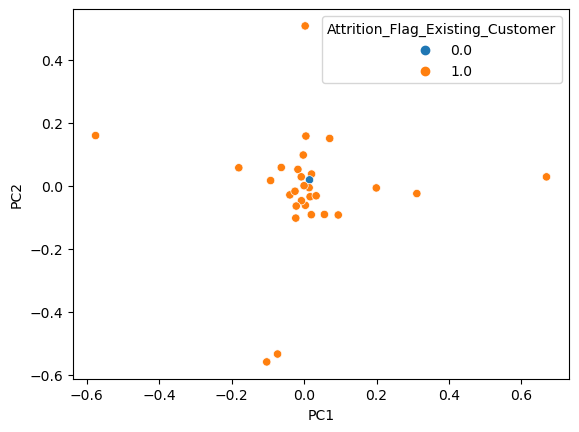

In [28]:
plot = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Attrition_Flag_Existing_Customer')

#### Scree Plot

Text(0, 0.5, 'Explained Variance')

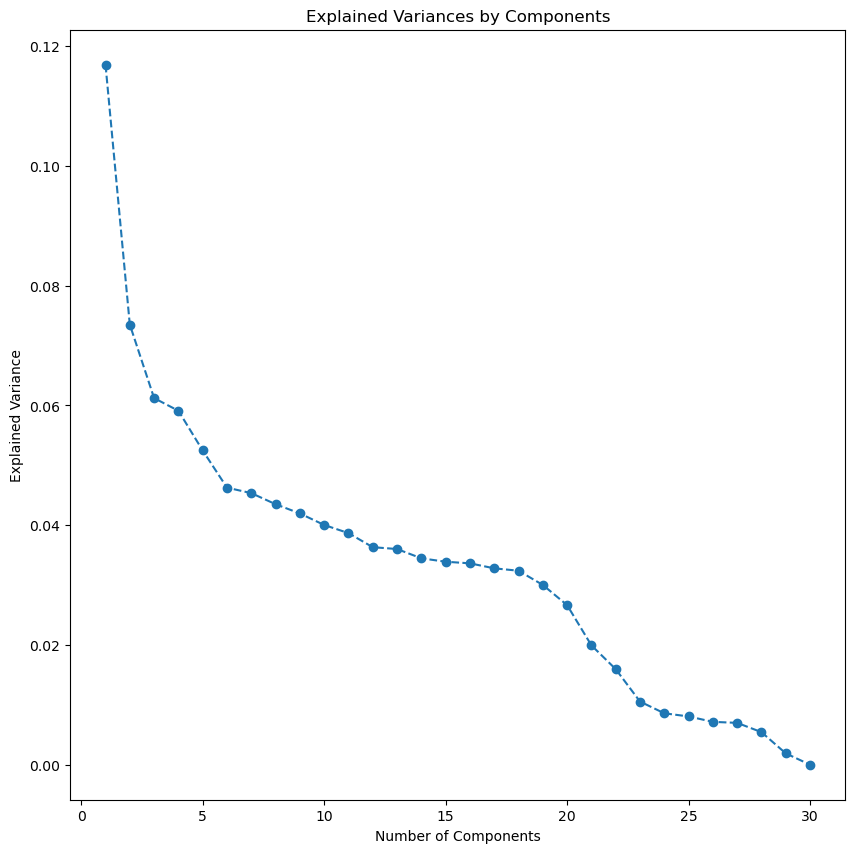

In [29]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,31), pca.explained_variance_ratio_, marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [30]:
#The percentage of variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

In [31]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(explained_variance):
  sum = sum + i
  if(sum > 0.7):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  14


#### Data Observations
- PCA shows that there is actually low variance between each feature, we can see this in the scatter plot as well
- Based on the scatter plot, it appears to be only 1 type of component that identifies the "Attrited Customer"
- This means that most of the data is closely related because we cannot find a high degree of variance between them
- 14 principle components explain majority of the data, but does it include the 1 component that explains the "Attrited Customer"?

### Get the index of the most important feature on EACH component using list comprehension

In [32]:
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [33]:
initial_feature_names = train_data_no_target.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [34]:
dict_intial_feature_names = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

### Shows the top 20 most influential columns in the dataset per component these columns are what I need to look at adding for my feature data set. Principal Component Analysis uses Singular Value Decomposition of the data to project it to a lower dimensional space

In [35]:
pca_train_data = pd.DataFrame(dict_intial_feature_names.items())

pca_train_data.head(20)

,0,1
0,PC0,Avg_Open_To_Buy
1,PC1,Total_Trans_Ct
2,PC2,Months_on_book
3,PC3,Marital_Status_Married
4,PC4,Marital_Status_Single
5,PC5,Total_Amt_Chng_Q4_Q1
6,PC6,Education_Level_Graduate
7,PC7,Income_Category_40K_60K
8,PC8,Income_Category_40K_60K
9,PC9,Education_Level_Uneducated


In [36]:
pca_train_data[1].unique()

array(['Avg_Open_To_Buy', 'Total_Trans_Ct', 'Months_on_book',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Total_Amt_Chng_Q4_Q1', 'Education_Level_Graduate',
       'Income_Category_40K_60K', 'Education_Level_Uneducated',
       'Income_Category_60K_80K', 'Education_Level_Post-Graduate',
       'Education_Level_Doctorate', 'Card_Category_Gold',
       'Card_Category_Platinum', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Relationship_Count',
       'Total_Ct_Chng_Q4_Q1', 'Card_Category_Silver', 'Gender_M',
       'Avg_Utilization_Ratio', 'Customer_Age', 'Total_Trans_Amt',
       'Income_Category_Less than $40K'], dtype=object)

#### Data Observations
- Select the top 14 since PCA said 14 components use 70% of variance

### PCA Training Data with top 14 only

In [37]:
pca_train_data_top_fourteen_only = train_data[['Attrition_Flag_Existing_Customer','Avg_Open_To_Buy', 'Total_Trans_Ct', 'Months_on_book',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Total_Amt_Chng_Q4_Q1', 'Education_Level_Graduate',
       'Income_Category_40K_60K', 'Education_Level_Uneducated',
       'Income_Category_60K_80K', 'Education_Level_Post-Graduate',
       'Education_Level_Doctorate', 'Card_Category_Gold',
       'Card_Category_Platinum']]
pca_train_data_top_fourteen_only.head()

,Attrition_Flag_Existing_Customer,Avg_Open_To_Buy,Total_Trans_Ct,Months_on_book,Marital_Status_Married,Marital_Status_Single,Total_Amt_Chng_Q4_Q1,Education_Level_Graduate,Income_Category_40K_60K,Education_Level_Uneducated,Income_Category_60K_80K,Education_Level_Post-Graduate,Education_Level_Doctorate,Card_Category_Gold,Card_Category_Platinum
0,1.0,11914.0,42.0,39.0,1.0,0.0,1.34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,7392.0,33.0,44.0,0.0,1.0,1.54,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3418.0,20.0,36.0,1.0,0.0,2.59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,796.0,20.0,34.0,0.0,0.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4716.0,28.0,21.0,1.0,0.0,2.17,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Hierarchical Clustering
- **Dendrogram** -Used to show the clustering relationship
- **Cluster Map** -Used to show the clustering relationship and visualize the variance of the clusters
- **Rand Score** -Used to show the clustering relationship and visualize the variance of the clusters

#### Dendrogram

In [38]:
# build the clusters using scipy library to show Dendrogram
clusters = hierarchy.linkage(train_data_no_target[0:1000] , method='single')

In [39]:
# build function to take cluster data and build dendrogram
def plot_dendrogram(clusters):
    plt.figure(figsize=(20,6))
    dendrogram = hierarchy.dendrogram(clusters, labels=list(train_data_target_only[0:1000]), orientation='top',leaf_font_size=9, leaf_rotation=360)
    plt.ylabel('Euclidean Distance');

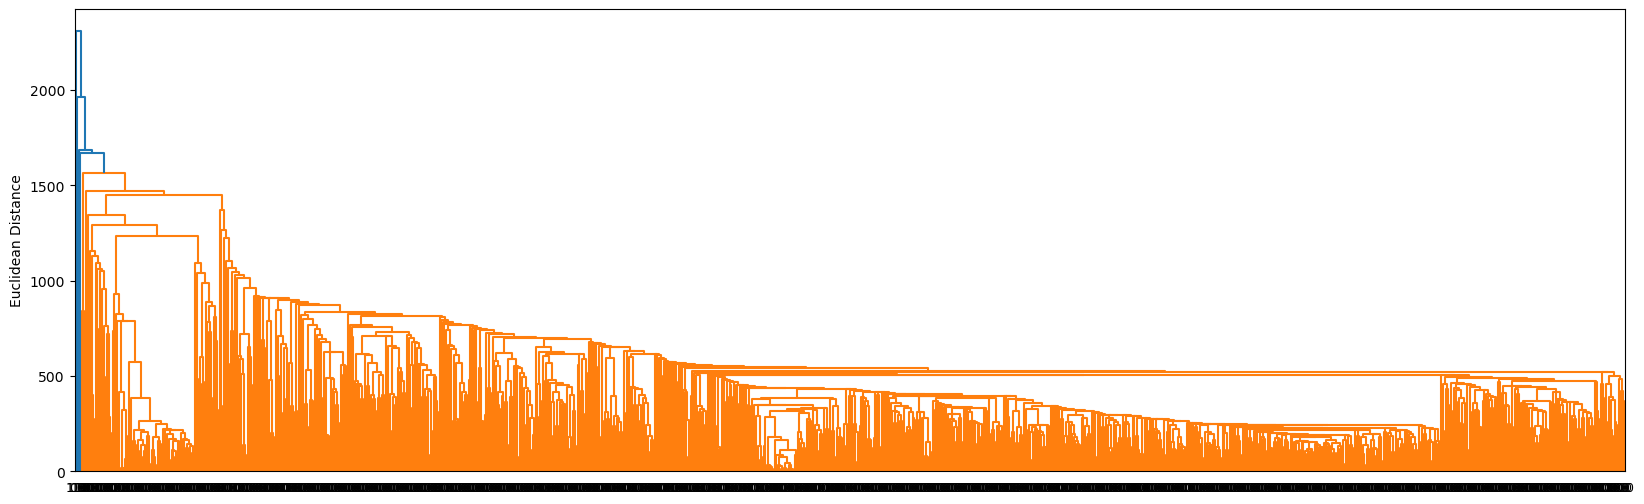

In [40]:
# build dendrogram
plot_dendrogram(clusters)

#### Cluster Map

C:\Users\frank\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


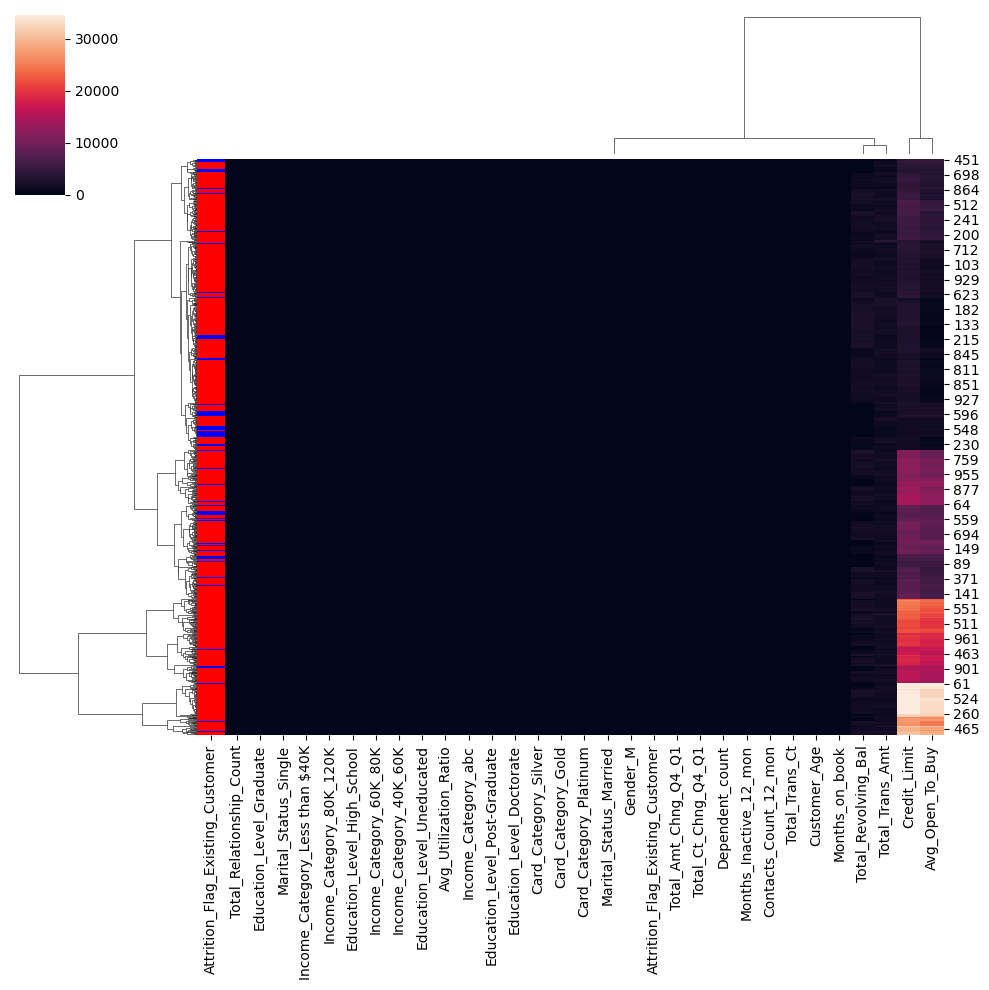

In [41]:
# load up 1000 rows of data
bank_churn_target_highlighted = dict(zip(train_data_target_only.unique(), "rbg"))
row_clrs = train_data_target_only[0:1000].map(bank_churn_target_highlighted)
sns.clustermap(train_data[0:1000], row_colors=row_clrs)

#### Rand Score

In [42]:
new_clusters = AgglomerativeClustering(n_clusters=14, linkage='single')
new_clusters_Y_pred = new_clusters.fit_predict(train_data_no_target[0:10000])

In [43]:
# using the adjusted_rand_score method for measuring the performance of the clustering algorithm by 
# giving original labels and predicted labels as input to the method. 
# It tries all possible pairs of clustering labels returns a value between -1.0 and 1.0. 
# If the clustering algorithm has predicted labels randomly then it'll return value of 0.0. 
# If the value of 1.0 is returned then it means that the algorithm predicted all labels correctly.
adjusted_rand_score(train_data_target_only[0:10000], new_clusters_Y_pred)

-0.0714107097075393

#### Data Observations

- I think the best "Cut" would be at Euclidean Distance level around 1,300
- I used the Euclidean Distance measure
- When designing my Hiearchical Clustering analysis, I wanted it to match the same approach as agglomerative clustering, which is a bottom-up approach. This is why I choose my linkage method to be "Single". For this assignment, I decided to keep using Euclidean Distance because I am still learning about classification and it's easy for me to confirm using pythagereon's theorem.  We can see that based on the rand score, the prediction is actually close to a random prediction rather than following the clustering group methodology.
- With comparing the results from principle analysis component, which was those features were probably part of just a few clusters and based on further analysis from PCA, it said that in order to get 70% variance, which would be considered "High" variance among the low variance components, I would need to include 14 principal components.

### K-Means Clustering

In [44]:
kmeans = KMeans(n_clusters = 14, random_state = 0, max_iter=1000,  n_init='auto')
kmeans.fit(X)
label = kmeans.fit_predict(pca_df)
print(label)

[ 8  9  5 11 13 10 10 13 10 10  8  2  0  8  0  4  0  6  4 10  2  1  8 10
 12  7  3 12 10  8]


C:\Users\frank\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


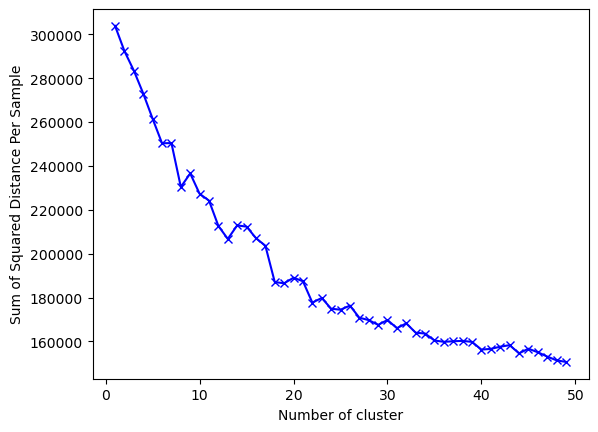

In [45]:
# step 1
SSDS = {} 

# step 2 - iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1,  n_init='auto').fit(X)
    SSDS[k] = kmeans.inertia_

# step 3
plt.figure()
plt.plot(list(SSDS.keys()), list(SSDS.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of Squared Distance Per Sample")
plt.show()

#### Data Observations
- I choose the number 14 for Kmeans clusters because while performing my principal component analysis, I saw that it showed me 14 groups in my scatter plot.
- The distance being used is shown in the Elbow Method chart, which shows the Sum of squared distances of samples to their closest cluster center.
- By reviewing the results from the charts, I can see that the distance decreases as the number of clusters increases and this would be related to low variance between the features as shown in the principal component analysis report because even the elbow method chart we can see, we have 14 clusters but we can also see that elbow shape is not yet clearly defined until more clusters are added, this consistent with the finds in the hierarchical clustering analysis and PCA where 70% of variance was defined by 14 features

### Data Preprocessing
These process applies only to Application Train dataset when needed
During this stage, even though the datasets are already split, I am splitting the training data into Train and Test data sets
and then after I will run it against the Application Test datasets for a prediction on the target

#### Feature Engineering
- Creating the X and y for the training data only.

- One train dataset of features of target will have just the TOP 14 columns from results of the principle component analysis.

- The other train dataset will include all the features.

- Create Oversample and Undersample pipeline because of imbalanced classifier.

In [46]:
df_train_features_top_fourteen = pca_train_data_top_fourteen_only.drop(['Attrition_Flag_Existing_Customer'], axis = 1)
df_train_target_top_fourteen = pca_train_data_top_fourteen_only.Attrition_Flag_Existing_Customer

df_train_features = train_data.drop(['Attrition_Flag_Existing_Customer'], axis = 1)
df_train_target = train_data.Attrition_Flag_Existing_Customer

#### Feature Selection
Splitting the training data and using the "stratify" feature because there are a lot more Target=0 than Target=1 and 
theres a chance that the during the split the we can have an imbalance and cause the models to be inaccurate
so here, I am giving my models the best chance to be accurate by performing an even split for them.

In [47]:
# Splitting the data
X_train_top_fourteen, X_test_top_fourteen, y_train_top_fourteen, y_test_top_fourteen = train_test_split(df_train_features_top_fourteen, 
                                                    df_train_target_top_fourteen, test_size = 0.3, random_state = 1, 
                                                    stratify = df_train_target_top_fourteen)

In [48]:
print("Shape of Training set with Top 14 variables: ", X_train_top_fourteen.shape)
print("Shape of test set with Top 14 variables: ", X_test_top_fourteen.shape)
print("Percentage of classes in training set with Top 14 variables:")
print(y_train_top_fourteen.value_counts(normalize=True))
print("Percentage of classes in test set with Top 14 variables:")
print(y_test_top_fourteen.value_counts(normalize=True))

Shape of Training set with Top 14 variables:  (7088, 14)
Shape of test set with Top 14 variables:  (3039, 14)
Percentage of classes in training set with Top 14 variables:
1.0    0.839306
0.0    0.160694
Name: Attrition_Flag_Existing_Customer, dtype: float64
Percentage of classes in test set with Top 14 variables:
1.0    0.839421
0.0    0.160579
Name: Attrition_Flag_Existing_Customer, dtype: float64


In [49]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df_train_features, 
                                                    df_train_target, test_size = 0.3, random_state = 1, 
                                                    stratify = df_train_target)

In [50]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (7088, 30)
Shape of test set :  (3039, 30)
Percentage of classes in training set:
1.0    0.839306
0.0    0.160694
Name: Attrition_Flag_Existing_Customer, dtype: float64
Percentage of classes in test set:
1.0    0.839421
0.0    0.160579
Name: Attrition_Flag_Existing_Customer, dtype: float64


###### Data Observation
- Huge imbalance on the target classifier values within the dataset
- 84% existing customers and 16% attrited customers
- Implement minority oversampling and majority random under sampling to help provide a more balanced solution

##### Implement Minority Oversampling and Majority Under Sampling
This is used to provide the models a more balanced set of data for training purposes only, not testing

In [51]:
# Define the oversampling method
oversample = SMOTE(sampling_strategy=0.75)
# Define the undersampling method
undersample = RandomUnderSampler(sampling_strategy=0.75)
# Define the pipeline
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)
#Fit the resample to X_train_resampled and Y_train_resampled
#resampling will only apply to training data.
#test data will be left alone with original representation of real world
X_train_top_fourteen_resampled, y_train_top_fourteen_resampled = pipeline.fit_resample(X_train_top_fourteen, y_train_top_fourteen)

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [52]:
print("Shape of Training set with Top 14 variables: ", X_train_top_fourteen_resampled.shape)
print("Shape of test set with Top 14 variables: ", X_test_top_fourteen.shape)
print("Percentage of classes in training set with Top 14 variables:")
print(y_train_top_fourteen_resampled.value_counts(normalize=True))
print("Percentage of classes in test set with Top 14 variables:")
print(y_test_top_fourteen.value_counts(normalize=True))

Shape of Training set with Top 14 variables:  (10409, 14)
Shape of test set with Top 14 variables:  (3039, 14)
Percentage of classes in training set with Top 14 variables:
1.0    0.571429
0.0    0.428571
Name: Attrition_Flag_Existing_Customer, dtype: float64
Percentage of classes in test set with Top 14 variables:
1.0    0.839421
0.0    0.160579
Name: Attrition_Flag_Existing_Customer, dtype: float64


In [53]:
print("Shape of Training set : ", X_train_resampled.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train_resampled.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (10409, 30)
Shape of test set :  (3039, 30)
Percentage of classes in training set:
1.0    0.571429
0.0    0.428571
Name: Attrition_Flag_Existing_Customer, dtype: float64
Percentage of classes in test set:
1.0    0.839421
0.0    0.160579
Name: Attrition_Flag_Existing_Customer, dtype: float64


###### Data Observsation
- after applying "SMOTE" for oversampling and a randomundersampling technique for the majority of the target, there's now a more balanced Target dataset.
- this will help with better predictions in the models used

### Model Building

Model Building made up of 2 parts:
- Model Selection
- Model Evaluation

#### Model Selection
This assignment wants me to use a classification tree/ decision tree and also a Random Forest.  
These will be the classification models used.
- **Decision Tree**
- **Random Forest**
- **Gradient Boosting Classifier**
- **XGBoost**
- **LightGBM**

#### Build Model Evaluation Criteria
The goal is to based on the Kaggle overview is to find bank customer attrition.


This would be Attrition_Flag_Existing_Customer=0, so Attrition_Flag_Existing_Customer=0 will be our true positive. it will be listed as "Attrited", 
else they are "Existing"

Below is a function to be used to create the classification report and the confusion matrix

In [54]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Attrited', 'Existing'], yticklabels=['Attrited', 'Existing'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#### Model Training and Evaluation

##### Build the Decision Tree Model 
Use only the TOP 14 variables I chose from my principle component analysis.

Those Top 14 variables are as follows:
- **Attrition_Flag_Existing_Customer**
- **Avg_Open_To_Buy**
- **Total_Trans_Ct**
- **Months_on_book**
- **Marital_Status_Married**
- **Marital_Status_Single**
- **Total_Amt_Chng_Q4_Q1**
- **Education_Level_Graduate**
- **Income_Category_40K_60K**
- **Education_Level_Uneducated**
- **Income_Category_60K_80K**
- **Education_Level_Post-Graduate**
- **Education_Level_Doctorate**
- **Card_Category_Gold**
- **Card_Category_Platinum**

###### Train the Decision Tree Classifier

In [55]:
dtc = tree.DecisionTreeClassifier(class_weight = 'balanced',
                                  criterion  = 'gini',
                                  max_features  =  'log2',
                                  min_samples_leaf  = 100,
                                  min_impurity_decrease = 0.01,
                                  random_state = 1);
dtc.fit(X_train_top_fourteen_resampled, y_train_top_fourteen_resampled)

DecisionTreeClassifier(class_weight='balanced', max_features='log2',
                       min_impurity_decrease=0.01, min_samples_leaf=100,
                       random_state=1)

###### Predict the Target for the Train and Test datasets

In [56]:
y_train_pred_dtc = dtc.predict(X_train_top_fourteen_resampled)
y_test_pred_dtc = dtc.predict(X_test_top_fourteen)

##### Check the Decision Tree Model Performance

              precision    recall  f1-score   support

         0.0       0.88      0.51      0.64      4461
         1.0       0.72      0.95      0.82      5948

    accuracy                           0.76     10409
   macro avg       0.80      0.73      0.73     10409
weighted avg       0.79      0.76      0.74     10409



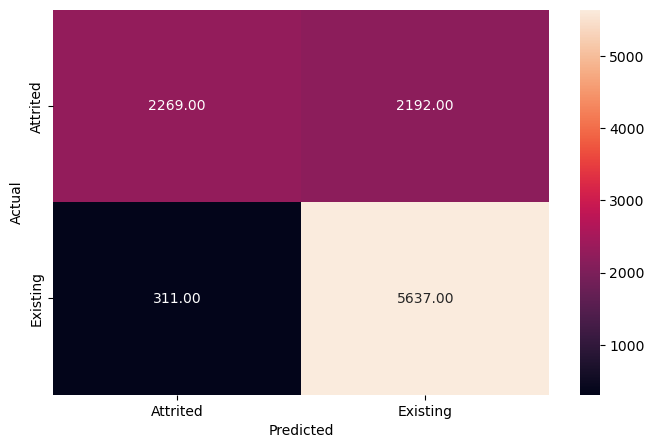

              precision    recall  f1-score   support

         0.0       0.52      0.27      0.36       488
         1.0       0.87      0.95      0.91      2551

    accuracy                           0.84      3039
   macro avg       0.70      0.61      0.63      3039
weighted avg       0.82      0.84      0.82      3039



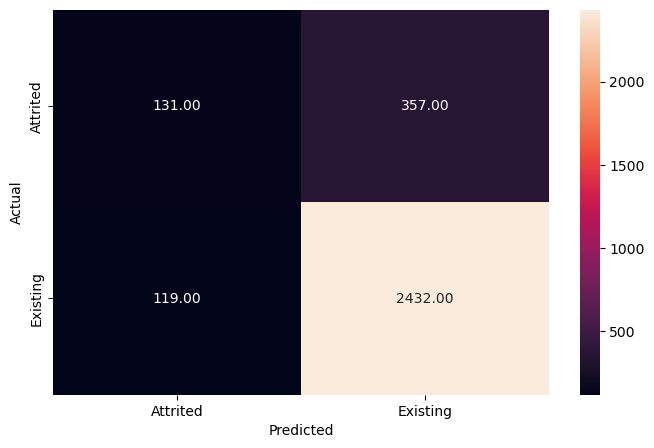

In [57]:
metrics_score(y_train_top_fourteen_resampled, y_train_pred_dtc)
metrics_score(y_test_top_fourteen, y_test_pred_dtc)

###### Visualize the Decision Classification Tree

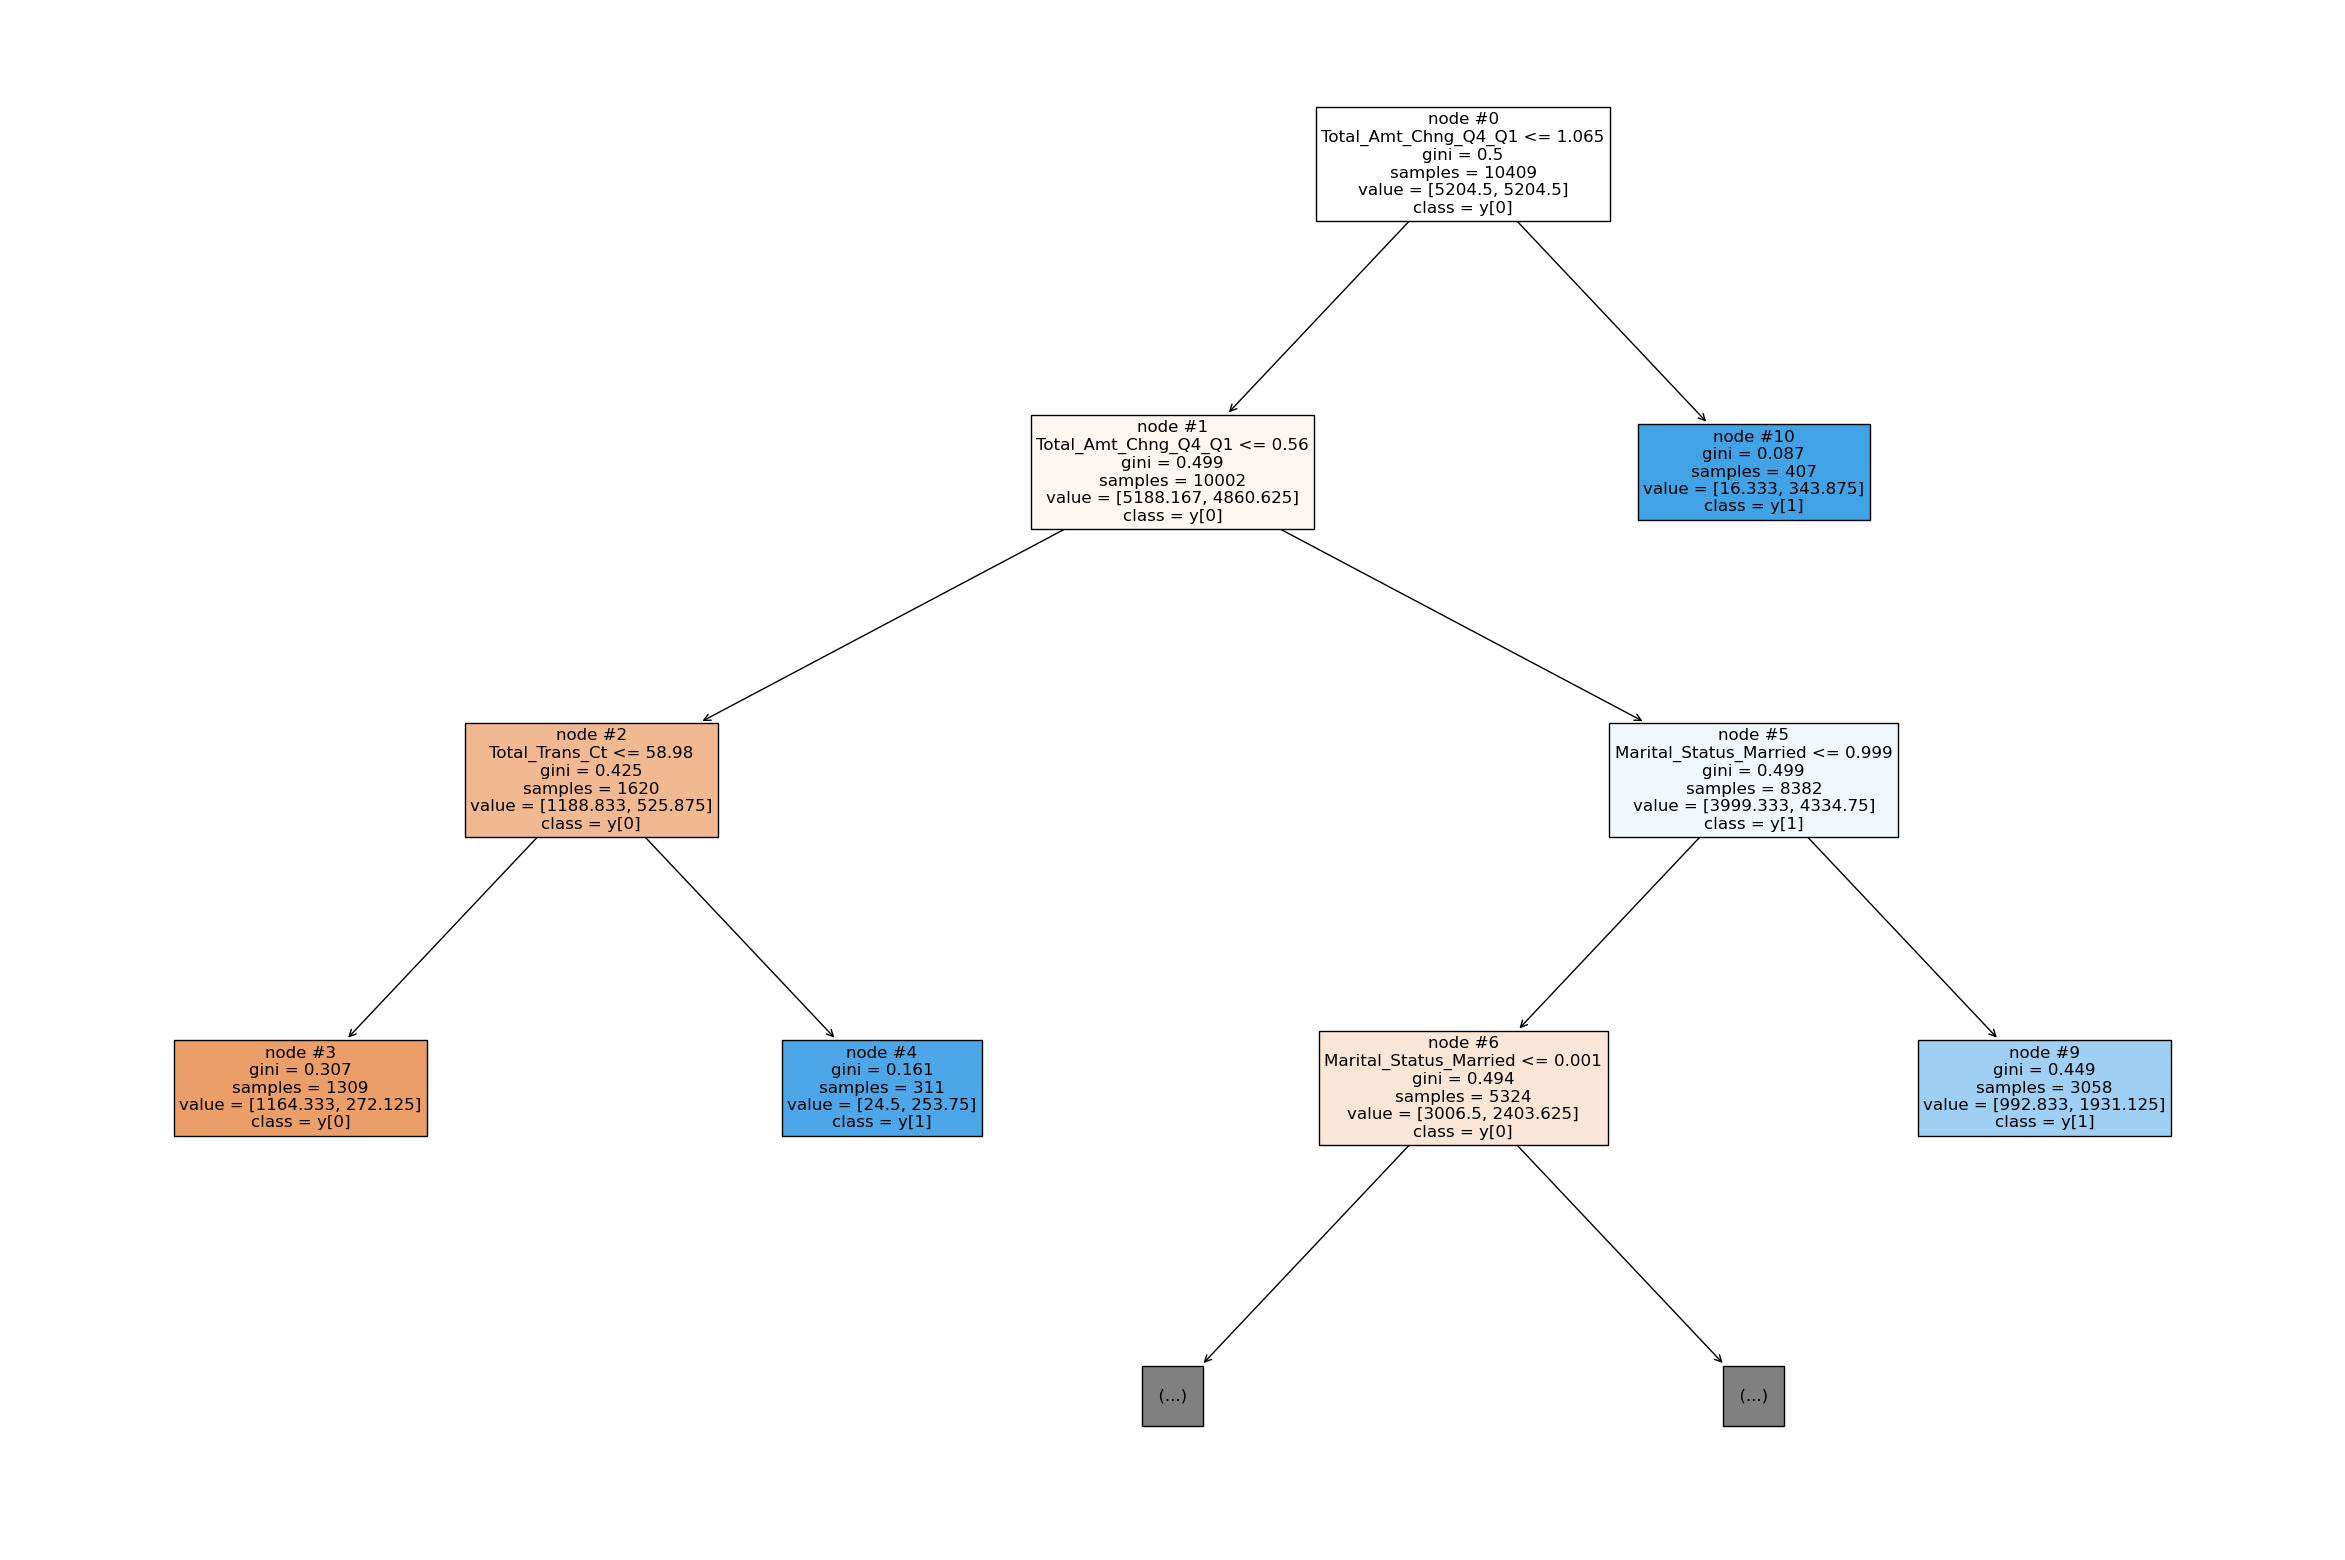

In [58]:
# feature names
f_names = list(df_train_features_top_fourteen.columns)
# plot the decision classification tree
plt.figure(figsize=(30,20))
tree.plot_tree(dtc, max_depth=3, feature_names = f_names, filled=True, fontsize=12, node_ids=True, class_names=True)
# show without rules in plain text
plt.show()

###### Get the Decision Classification Tree Path

In [59]:
dtc.decision_path(X_train_top_fourteen_resampled)

<10409x11 sparse matrix of type '<class 'numpy.int64'>'
	with 46146 stored elements in Compressed Sparse Row format>

###### Get the Decision Classification Tree Depth

In [60]:
dtc.get_depth()

4

###### Get the number of leaves on the Decision Classification Tree

In [61]:
dtc.get_n_leaves()

6

###### Get the Decision Classification Tree Parameters used

In [62]:
dtc.get_params(deep=True)

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

##### Data Observations
- Decision Classification Tree has recall score for "Attrited" at 25% and also a low F1 score for "Attrited" witht the test dataset
- This is a low recall score as the prediction rate will be very low for this model using the entire dataset
- The top fourteen as listed does not include the feature listed to find the "Attrited Customers"
- Since accuracy for the test dataset is in the range of similar or better than the training dataset, we know this model would we can expect any other dataset to provide a result like this with the model

###### Run it again but pre-pruning
Pre-pruning the tree with following parameters:

- max_depth at 4, I used this because I saw the max depth was 4 when visualizing my decision classification tree
- criterion set for entropy to also help with information gain
- min_samples_leaf with 6, the default is set to 2
- using the top 14 principal components from the principal component analysis

              precision    recall  f1-score   support

         0.0       0.63      0.23      0.34      4461
         1.0       0.61      0.90      0.73      5948

    accuracy                           0.61     10409
   macro avg       0.62      0.56      0.53     10409
weighted avg       0.62      0.61      0.56     10409



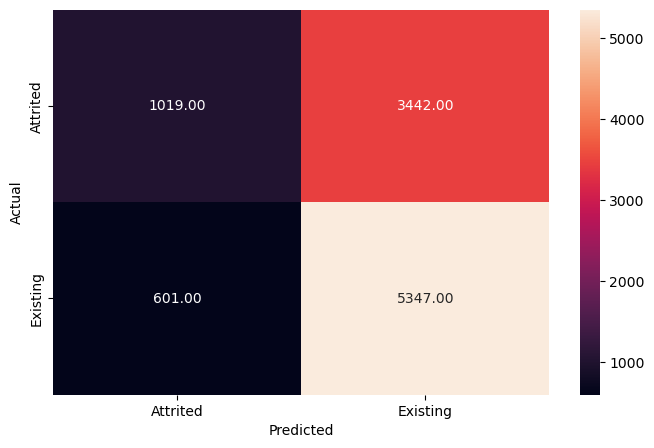

              precision    recall  f1-score   support

         0.0       0.36      0.29      0.32       488
         1.0       0.87      0.90      0.89      2551

    accuracy                           0.80      3039
   macro avg       0.61      0.60      0.60      3039
weighted avg       0.79      0.80      0.79      3039



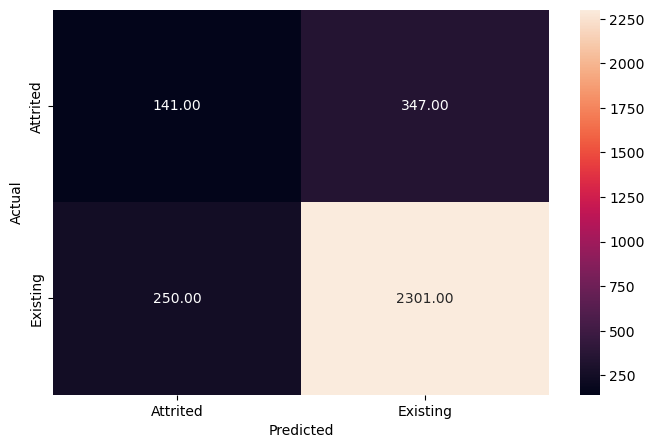

In [63]:
dtc_pre_pruned = DecisionTreeClassifier(class_weight = 'balanced',
                                        max_depth = 4,
                                        criterion = 'gini',
                                        min_samples_leaf = 1000,
                                        max_features = 'log2',
                                        min_impurity_decrease = 0.01,
                                        min_samples_split = 6,
                                        random_state = 1);
dtc_pre_pruned.fit(X_train_top_fourteen_resampled, y_train_top_fourteen_resampled)

y_train_pred_dtc_pre_pruned = dtc_pre_pruned.predict(X_train_top_fourteen_resampled)
y_test_pred_dtc_pre_pruned = dtc_pre_pruned.predict(X_test_top_fourteen)

metrics_score(y_train_top_fourteen_resampled, y_train_pred_dtc_pre_pruned)
metrics_score(y_test_top_fourteen, y_test_pred_dtc_pre_pruned)

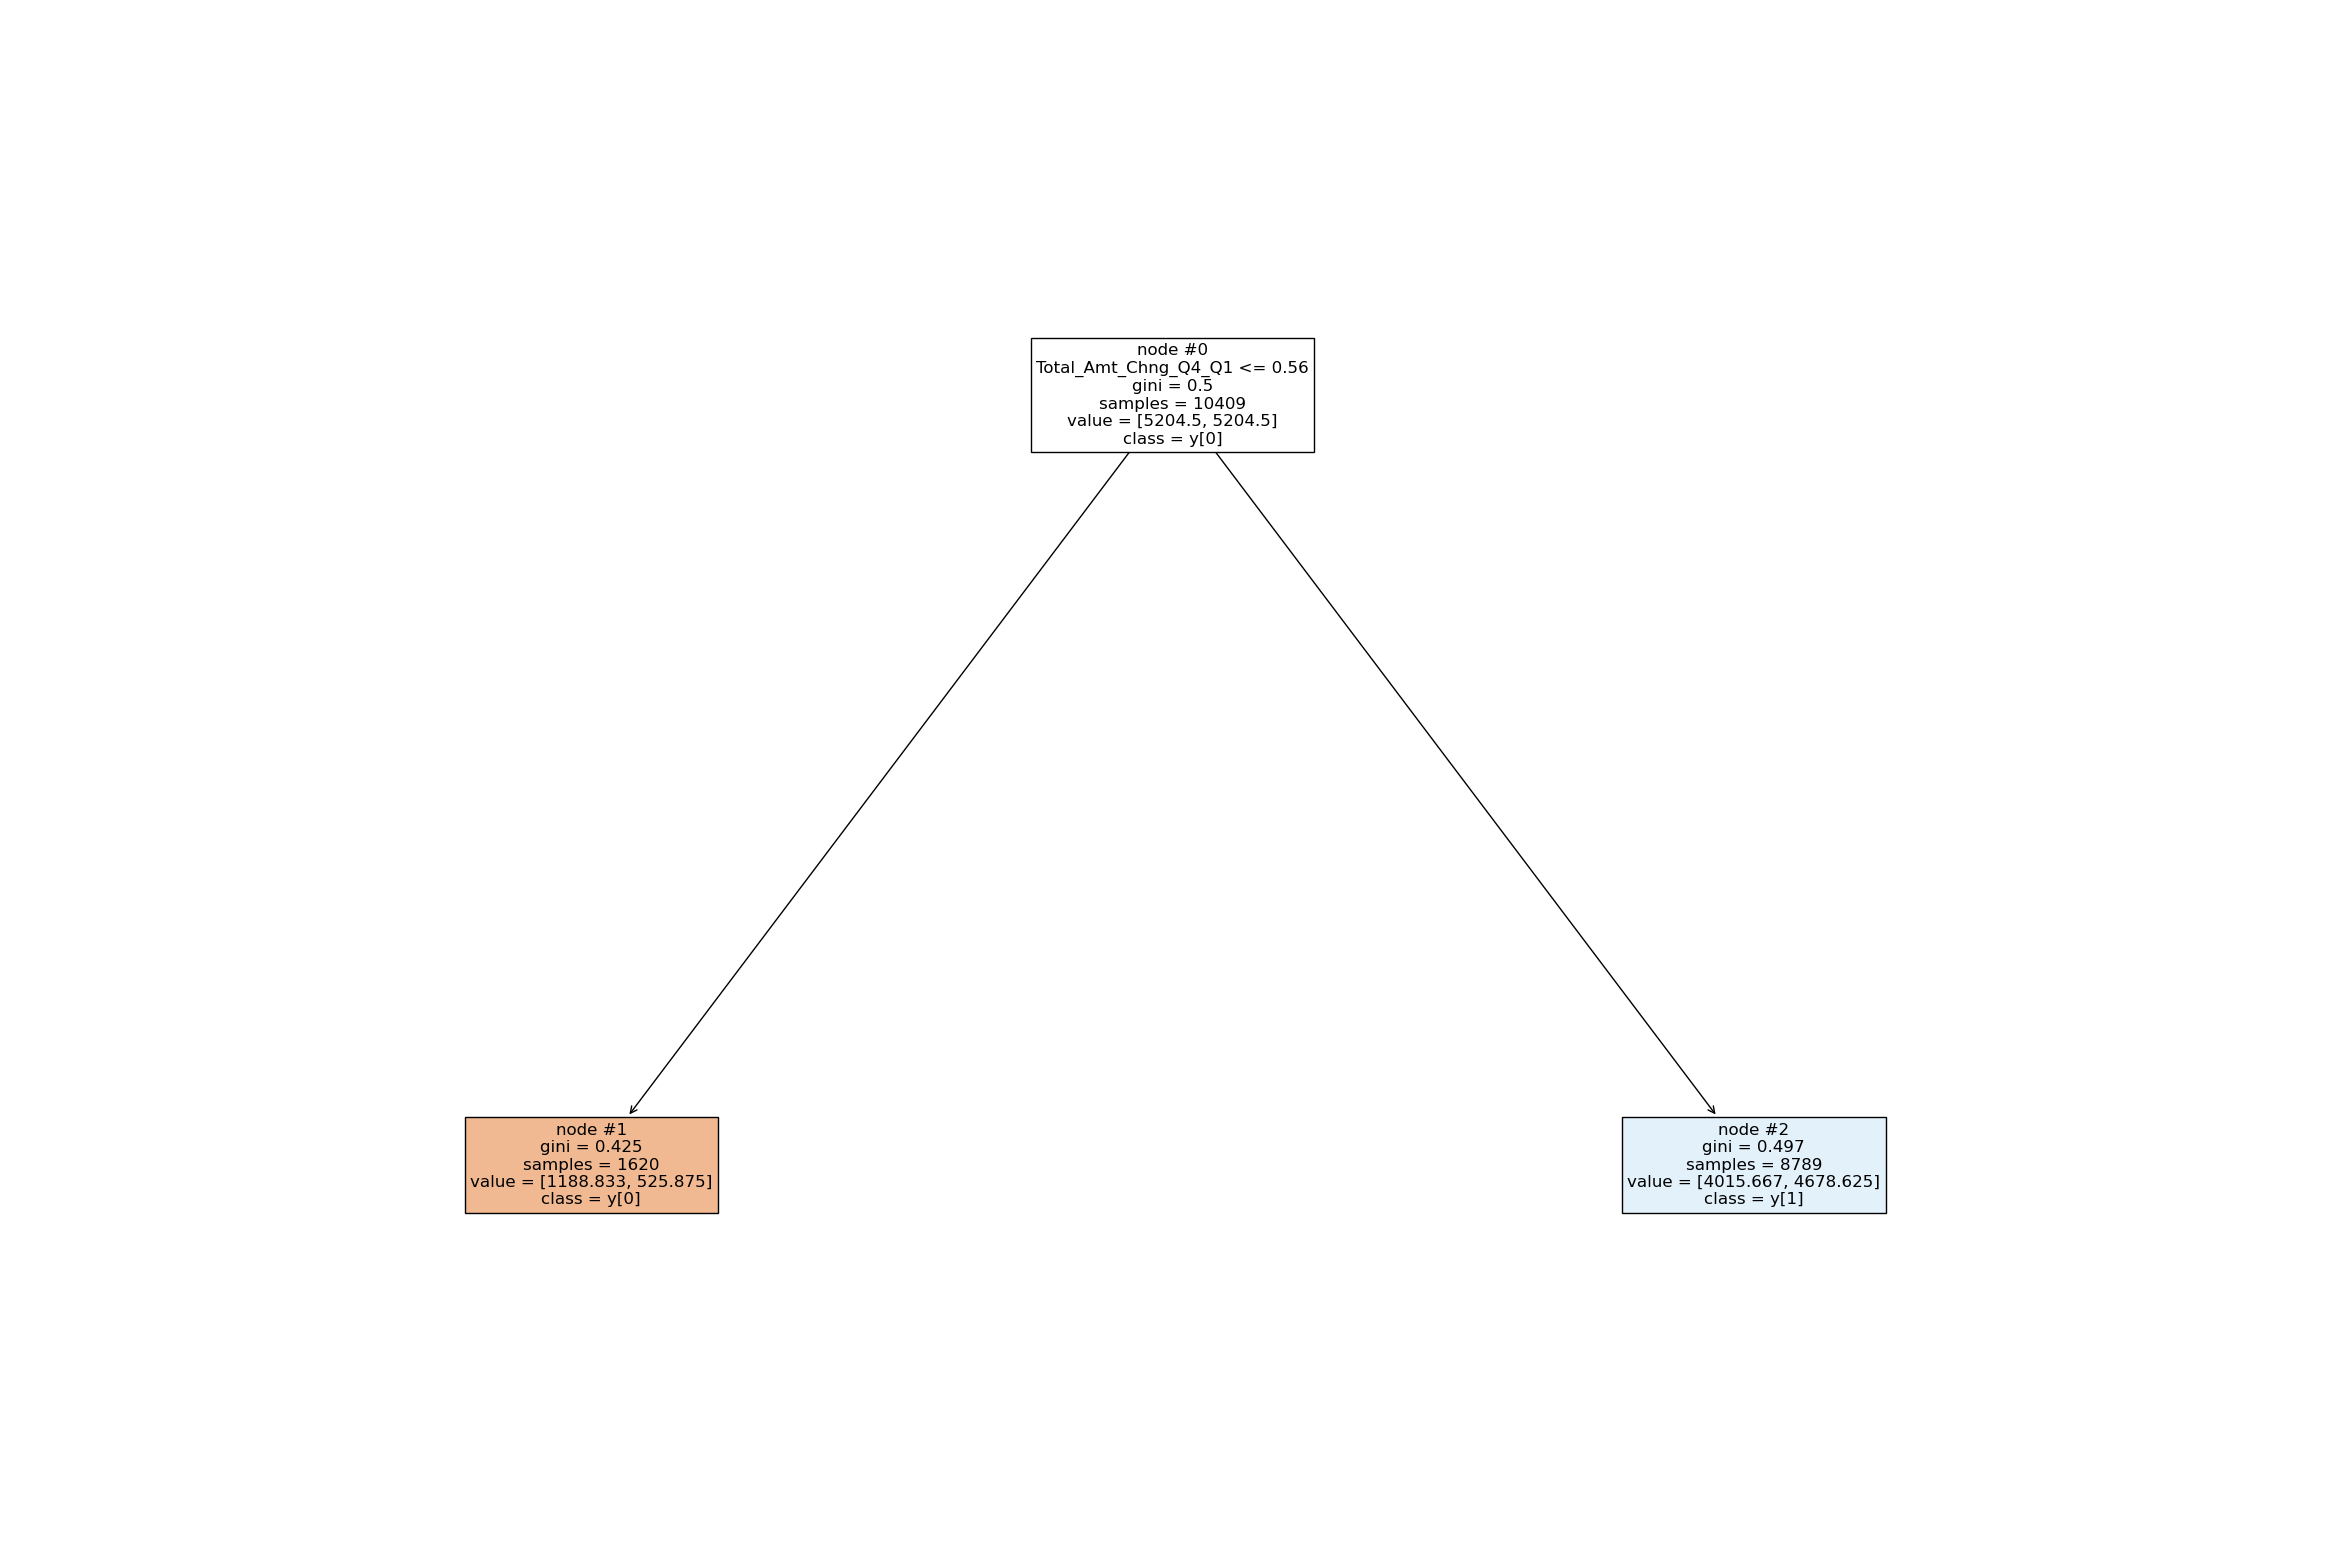

In [64]:
# feature names
f_names = list(df_train_features_top_fourteen.columns)
# plot the decision classification tree
plt.figure(figsize=(30,20))
tree.plot_tree(dtc_pre_pruned, max_depth=4, feature_names = f_names, filled=True, fontsize=12, node_ids=True, class_names=True)
# show without rules in plain text
plt.show()

##### Data Observations
- Decision Classification Tree has recall score for "Attrited" at 26%.
- The recall score was an not an improvement from the original.
- This is a low score as well as low F1 score for the "Attrited", as the prediction rate will be very low for this model

##### Build the Random Forest Model
- Run the Random Forest Model with entire feature dataset
- Using the same max_depth as set for the Decision Tree Classifier
- Adding in balanced class weights and reducing the gini impurity to help with overfitting of data 

In [65]:
# parameterize cross validation
crossvalidation = KFold(n_splits = 14,shuffle = True,random_state = 1)

# override the GradientBoostingClassifier function
RFC = RandomForestClassifier()
RFC_search_grid = {'min_samples_split':[2,4,6], 'min_samples_leaf': [250, 500, 1000], 'max_depth': [4,12,24], 
               'min_impurity_decrease': [.0001,.001,.01],'random_state':[1]}
RFC_search = GridSearchCV(estimator = RFC, param_grid = RFC_search_grid, scoring = 'recall', n_jobs = 1, cv = crossvalidation)

#shows the results of the model that will run
RFC_search

GridSearchCV(cv=KFold(n_splits=14, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [4, 12, 24],
                         'min_impurity_decrease': [0.0001, 0.001, 0.01],
                         'min_samples_leaf': [250, 500, 1000],
                         'min_samples_split': [2, 4, 6], 'random_state': [1]},
             scoring='recall')

###### Train the Random Forest Model

In [66]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = 'balanced',
                                        max_depth = 24,
                                        criterion = 'gini',
                                        min_samples_leaf = 1000,
                                        max_features = 'log2',
                                        min_impurity_decrease = 0.01,
                                        min_samples_split = 6,
                                        random_state = 1)

rf_estimator.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       max_features='log2', min_impurity_decrease=0.01,
                       min_samples_leaf=1000, min_samples_split=6,
                       random_state=1)

In [67]:
# fit to the model and find the best parameters to run the model
#X_train, X_test, y_train, y_test
#search.fit(X_train,y_train)
#print(search.best_params_)
#print(search.best_score_)

###### Predict the Target for the Train and Test datasets

In [68]:
y_pred_train_rf = rf_estimator.predict(X_train_resampled)
y_pred_test_rf = rf_estimator.predict(X_test)

##### Check the Random Forest Model Performance

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      4461
         1.0       0.88      0.86      0.87      5948

    accuracy                           0.85     10409
   macro avg       0.85      0.85      0.85     10409
weighted avg       0.85      0.85      0.85     10409



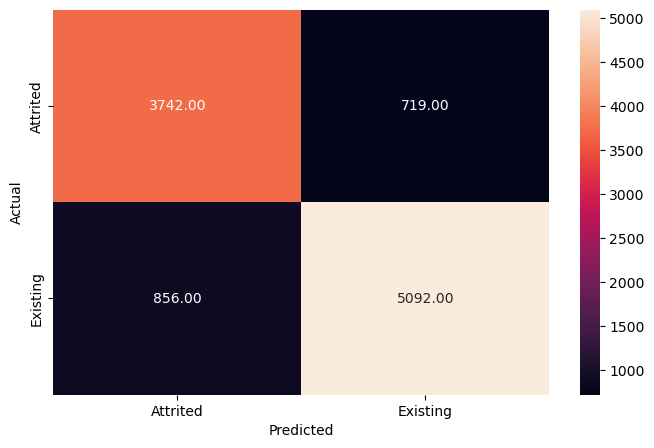

              precision    recall  f1-score   support

         0.0       0.48      0.76      0.59       488
         1.0       0.95      0.84      0.89      2551

    accuracy                           0.83      3039
   macro avg       0.72      0.80      0.74      3039
weighted avg       0.87      0.83      0.85      3039



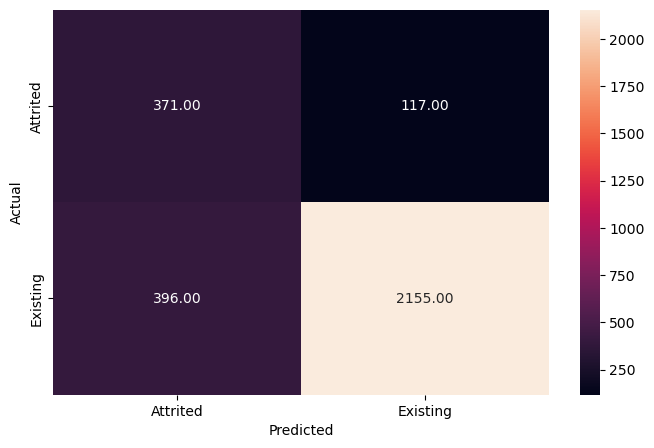

In [69]:
# Checking performance on the training data
metrics_score(y_train_resampled, y_pred_train_rf)
metrics_score(y_test, y_pred_test_rf)

##### List the top fifthteen variables from the feature importances

<Axes: xlabel='Importance'>

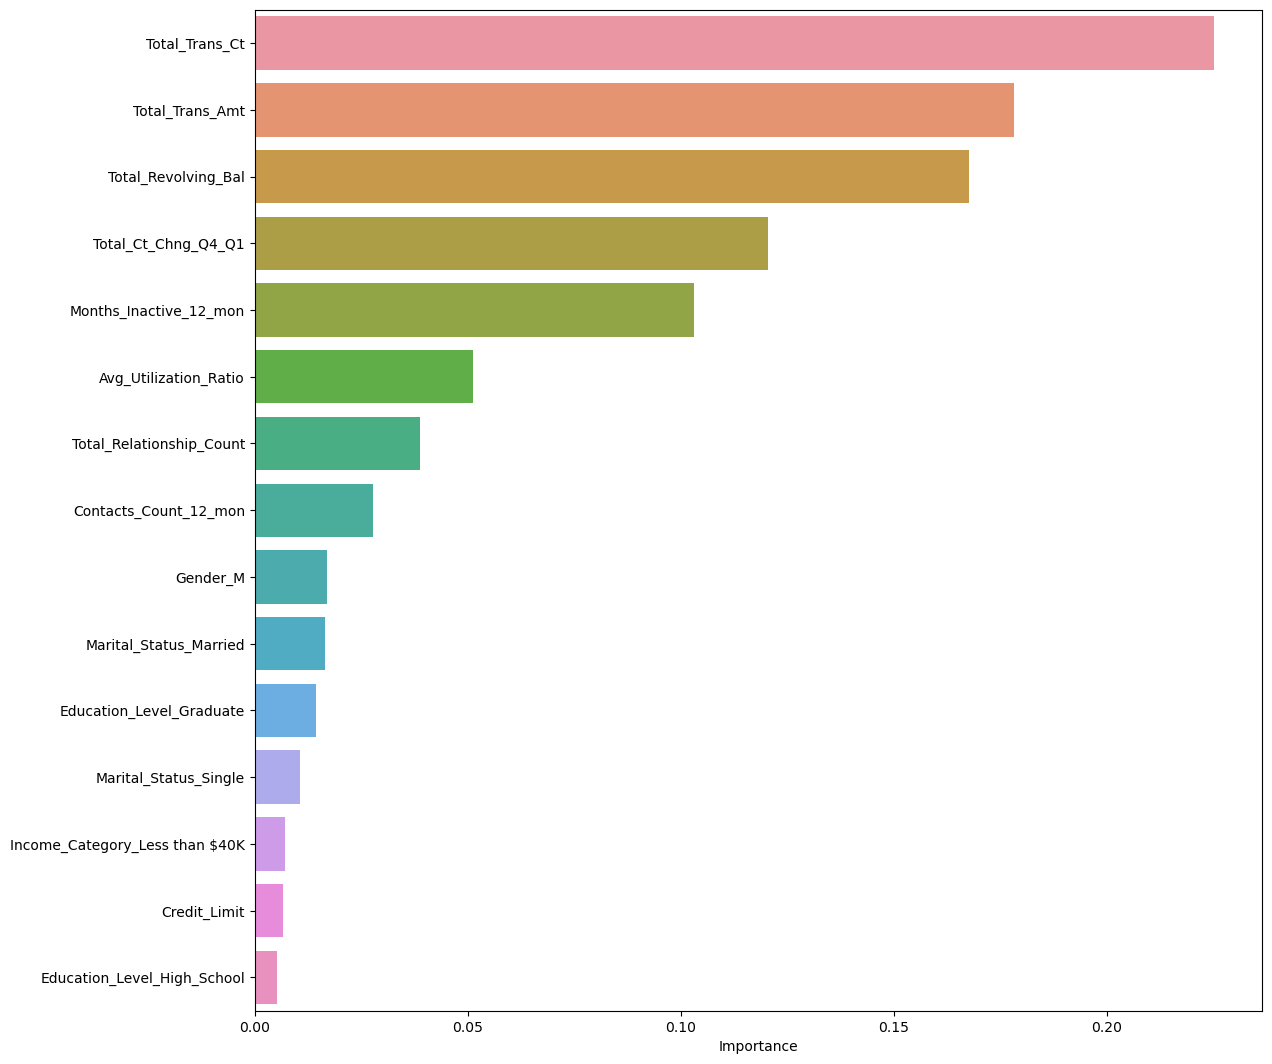

In [70]:
importances = rf_estimator.feature_importances_

columns = df_train_features.columns

importance_df = pd.DataFrame(importances, index = columns, 
                             columns = ['Importance']).sort_values(by = 'Importance', ascending = False).nlargest(15,columns='Importance')

plt.figure(figsize = (13, 13))

sns.barplot(data = importance_df, x = 'Importance', y = importance_df.index)

###### Data Observation
- the top 15 most important variables are much different than my original list of 14 variables generated from Principal Component Analysis during the Exploratory Data Analysis Stage.  The only features that are the same are as follows: 
- I used 24 for the max depth because in a long running GridSearchCV, it found it to be the best case scenario parameter
- **Total_Trans_Ct**
- **Marital Status for Married and Single**
- The recall score improved to 76% for 'Attrited'
- The F1 score for 'Attrited' is 58% which is still a low score

##### Build the Gradient Boosting Model
- First build out your Gradient Boosting Model parameters arrays.
- Run the Gradient Boosting model with the entire data set.
- Then compare the dataset with the other models. 

In [71]:
# parameterize cross validation
crossvalidation = KFold(n_splits = 14,shuffle = True,random_state = 1)

# override the GradientBoostingClassifier function
GBC = GradientBoostingClassifier()
search_grid = {'n_estimators':[500,1000,2000], 'learning_rate': [.001, 0.01, .1], 'max_depth': [4,12,24], 
               'subsample': [.5,.75,1],'random_state':[1]}
search = GridSearchCV(estimator = GBC, param_grid = search_grid, scoring = 'recall', n_jobs = 1, cv = crossvalidation)

#shows the results of the model that will run
search


GridSearchCV(cv=KFold(n_splits=14, random_state=1, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 12, 24],
                         'n_estimators': [500, 1000, 2000], 'random_state': [1],
                         'subsample': [0.5, 0.75, 1]},
             scoring='recall')

In [72]:
# fit to the model and find the best parameters to run the model
#X_train, X_test, y_train, y_test
#search.fit(X_train,y_train)
#print(search.best_params_)
#print(search.best_score_)

In [73]:
# run the Gradient Boosting Classifier with the best parameters found
newGBC = GradientBoostingClassifier(validation_fraction = 0.10,
                                    n_iter_no_change=3,
                                    tol = 0.01,
                                    max_depth = 24,
                                    criterion = 'friedman_mse',
                                    min_samples_leaf = 1000,
                                    max_features = 'log2',
                                    min_impurity_decrease = 0.01,
                                    min_samples_split = 6,
                                    n_estimators = 2000,
                                    learning_rate = 0.01,
                                    subsample = .75,
                                    random_state = 1)
newGBC.fit(X_train_resampled,y_train_resampled)

GradientBoostingClassifier(learning_rate=0.01, max_depth=24,
                           max_features='log2', min_impurity_decrease=0.01,
                           min_samples_leaf=1000, min_samples_split=6,
                           n_estimators=2000, n_iter_no_change=3,
                           random_state=1, subsample=0.75, tol=0.01)

In [74]:
#train and test the Gradient Boosting Classifier
y_hat_new_GBC = newGBC.predict(X_train_resampled) # predict the train dataset
y_pred_new_GBC = newGBC.predict(X_test) # predict the test dataset

              precision    recall  f1-score   support

         0.0       0.98      0.33      0.49      4461
         1.0       0.66      1.00      0.80      5948

    accuracy                           0.71     10409
   macro avg       0.82      0.66      0.64     10409
weighted avg       0.80      0.71      0.66     10409



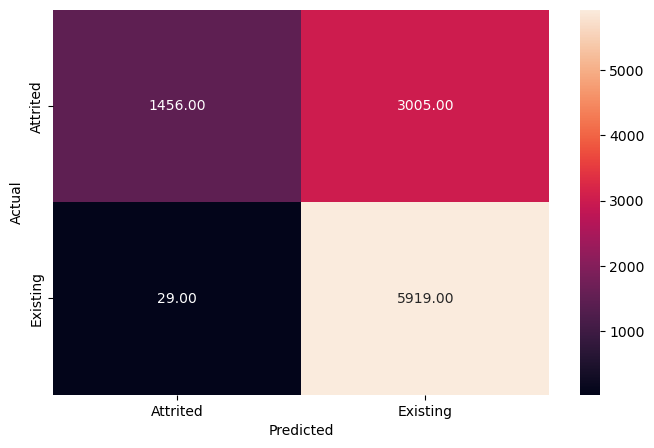

              precision    recall  f1-score   support

         0.0       0.95      0.25      0.39       488
         1.0       0.87      1.00      0.93      2551

    accuracy                           0.88      3039
   macro avg       0.91      0.62      0.66      3039
weighted avg       0.89      0.88      0.85      3039



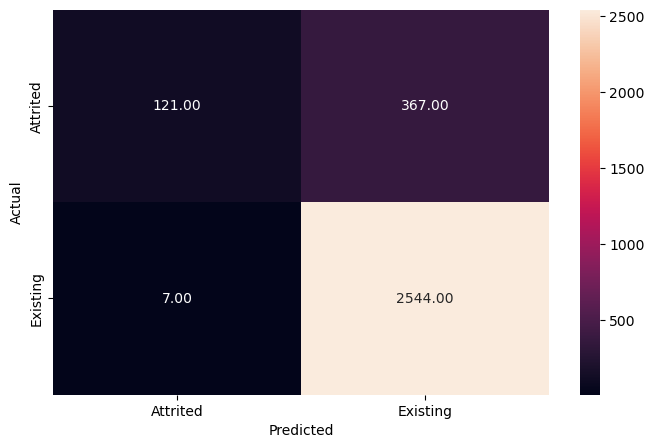

In [75]:
# Checking performance on the training data
metrics_score(y_train_resampled, y_hat_new_GBC)
metrics_score(y_test, y_pred_new_GBC)

<Axes: xlabel='Importance'>

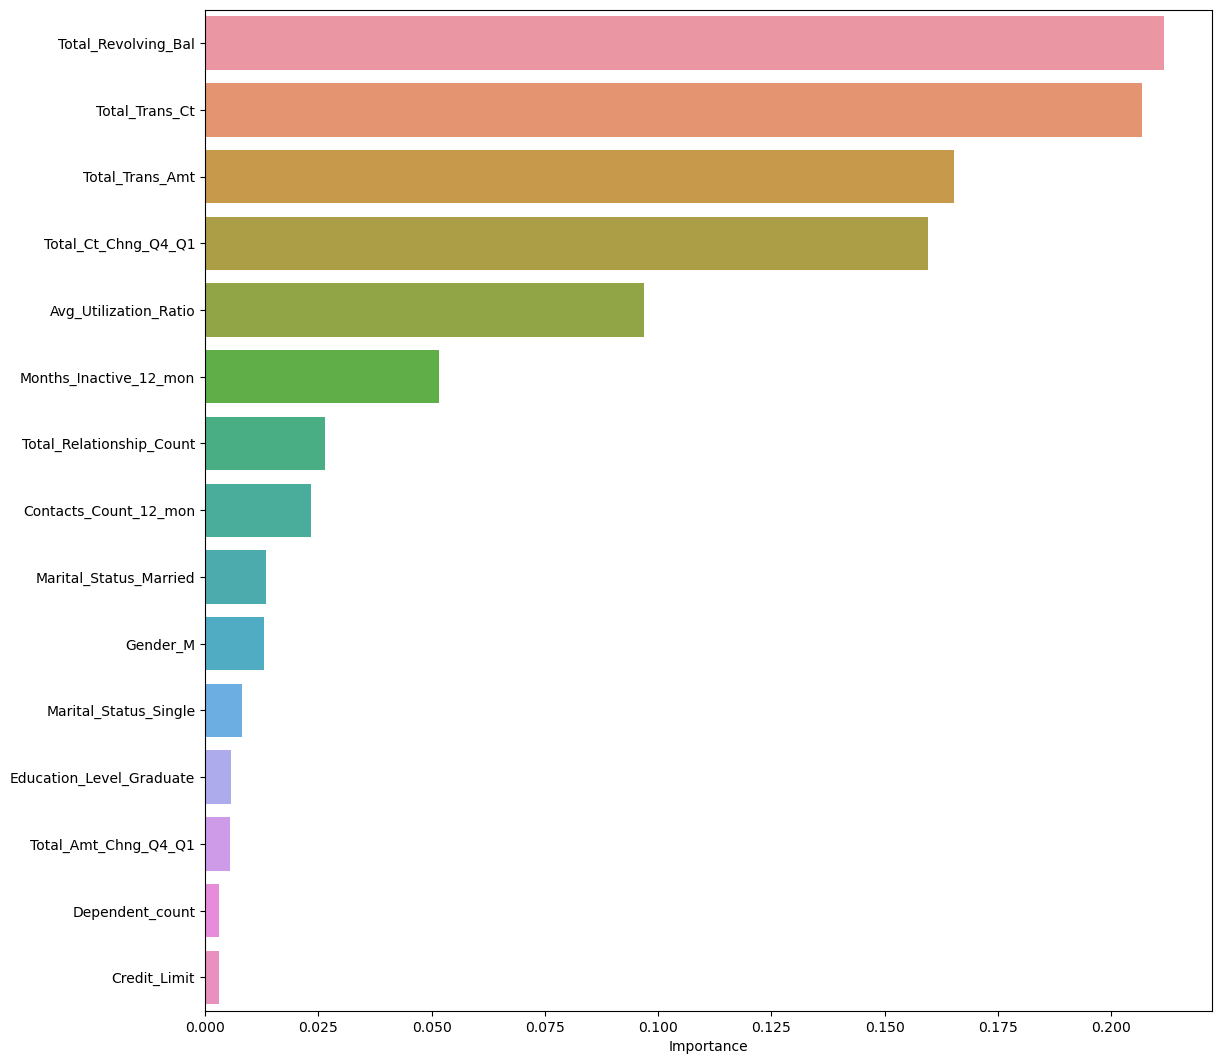

In [76]:
newGBC_importances = newGBC.feature_importances_

columns = df_train_features.columns

newGBC_importance_df = pd.DataFrame(newGBC_importances, index = columns, 
                             columns = ['Importance']).sort_values(by = 'Importance', ascending = False).nlargest(15,columns='Importance')

plt.figure(figsize = (13, 13))

sns.barplot(data = newGBC_importance_df, x = 'Importance', y = newGBC_importance_df.index)

##### Data Observations
- Gradient Boost Classifier has recall score for 'Attrited' at 27%.
- This is lower than the Random Forest Classifier model, the precision for 'Attrited' is much better than Random Forest Classifier model.
- The F1-Score for 'Attrited' is 42%, which is lower than Random Forest Classifier
- With better parameters, this could be a viable option for final model to deploy
- The most important features are the same as Random Forest

#### Build the XGBoost Model
- Apply the parameters
- Build the model
- Fit and Predict the data for the model
- Evaluate the model

In [77]:
#Build the model
newXGBoost = XGBClassifier(max_depth = 24,
                           n_estimators = 2000,
                           learning_rate = 0.01,
                           subsample = .75,
                           sampling_method = 'uniform',
                           min_split_loss = 75,
                           reg_lambda = 45,
                           reg_alpha = 25,
                           seed = 1)

In [78]:
#Fit the model
newXGBoost.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=24, max_leaves=None,
              min_child_weight=None, min_split_loss=75, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [79]:
#train and test the XGBoost Classifier
y_hat_new_XGBoost = newXGBoost.predict(X_train_resampled) # predict the train dataset
y_pred_new_XGBoost = newXGBoost.predict(X_test) # predict the test dataset

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      4461
         1.0       0.95      0.95      0.95      5948

    accuracy                           0.94     10409
   macro avg       0.94      0.94      0.94     10409
weighted avg       0.94      0.94      0.94     10409



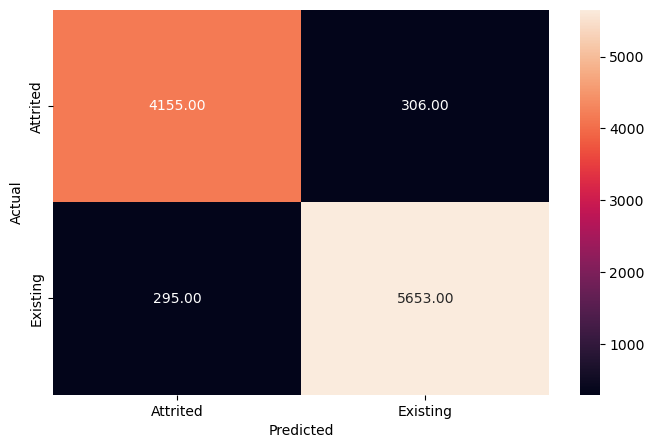

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       488
         1.0       0.97      0.95      0.96      2551

    accuracy                           0.93      3039
   macro avg       0.87      0.90      0.88      3039
weighted avg       0.94      0.93      0.93      3039



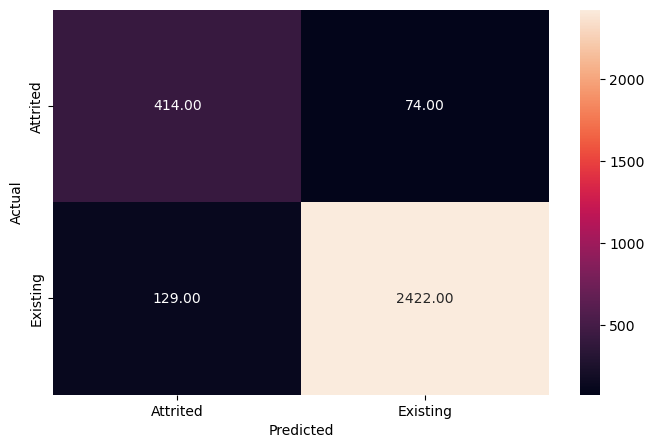

In [80]:
# Evaluate the model
# Checking performance on the training data
metrics_score(y_train_resampled, y_hat_new_XGBoost)
metrics_score(y_test, y_pred_new_XGBoost)

<Axes: xlabel='Importance'>

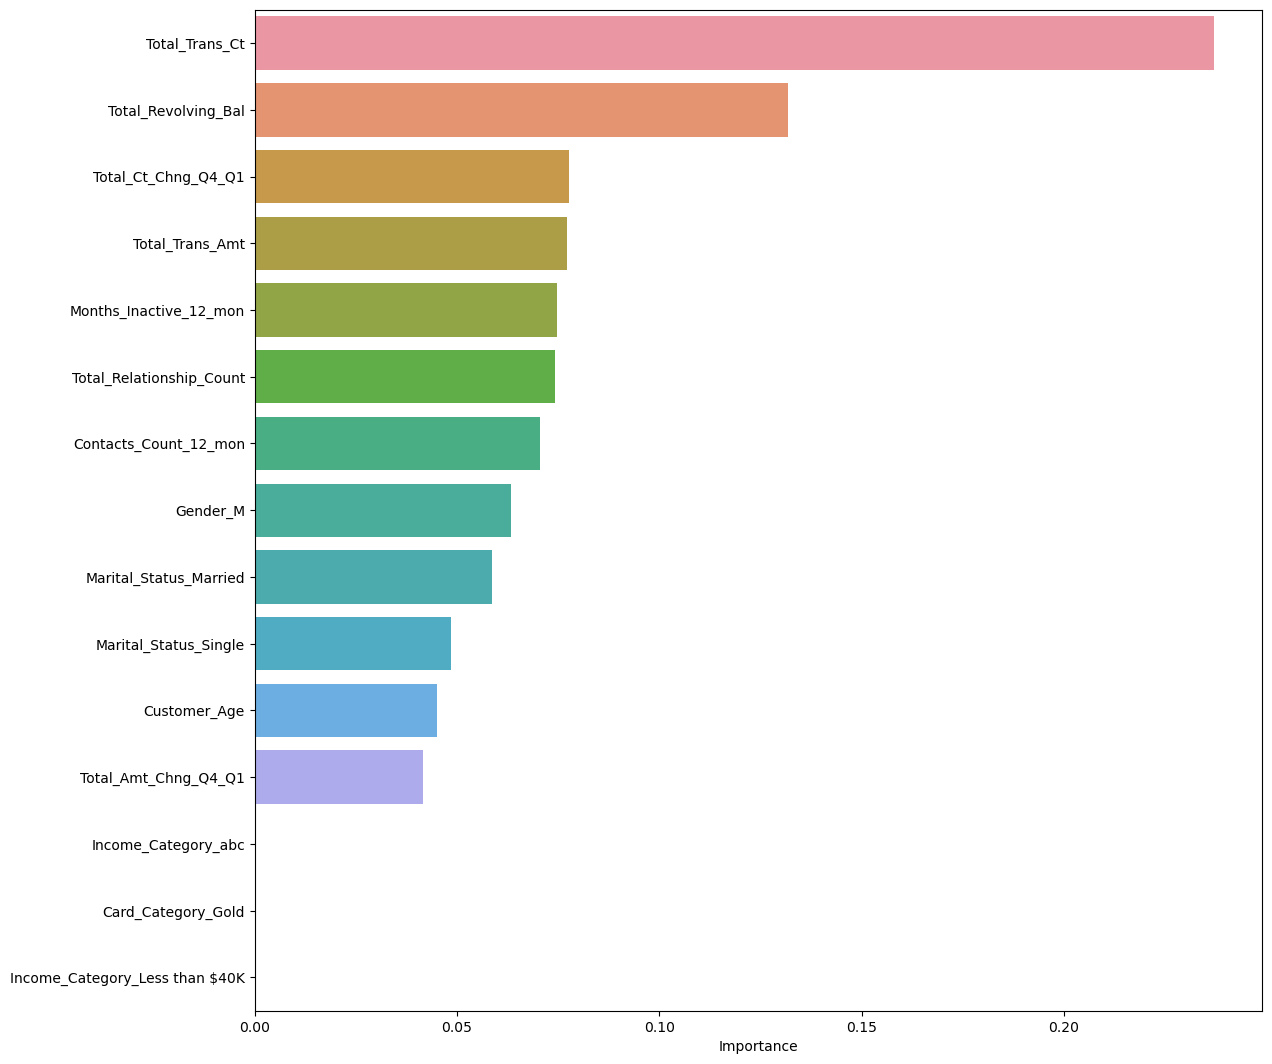

In [81]:
newXGBoost_importances = newXGBoost.feature_importances_

columns = df_train_features.columns

newXGBoost_importance_df = pd.DataFrame(newXGBoost_importances, index = columns, 
                             columns = ['Importance']).sort_values(by = 'Importance', ascending = False).nlargest(15,columns='Importance')

plt.figure(figsize = (13, 13))

sns.barplot(data = newXGBoost_importance_df, x = 'Importance', y = newXGBoost_importance_df.index)

##### Data Observations
- XGBoost has the best performance out of all the models, even without manipulating any hyperparameters, with a recall value on 'Attrited' at 85% and an F1 score of 80% for 'Attrited' customers.
- This is a high recall score as the prediction rate will be very high for this model
- With better parameters applied, this could be the best option for final model to deploy
- The most important features are again, majority the same as Random Forest and Gradient Boost Classifier
- The features listed will be the most important in why customers are either leaving or staying at the bank.
- There will have to be more in-depth analysis done by the bank on the top 5 features as 3 different models found them the most important

#### Light GBM

In [82]:
# Convert the data into LightGBM Dataset format
lgbm_train_data = lgbm.Dataset(X_train_resampled, label=y_train_resampled)
lgbm_test_data = lgbm.Dataset(X_test, label=y_test)

# Define parameters for the model
params = {'max_depth':24,'n_estimators':2000,'reg_lambda':45,'reg_alpha':25,'seed':1,
          'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 3,
          'metric': 'multi_logloss', 'learning_rate': 0.01, 'num_leaves': 31,
          'early_stopping':10,'log_evaluation':'False', 'verbose': -1}

# Train the model
lgb_model = lgbm.train(params, lgbm_train_data, valid_sets=[lgbm_test_data])

C:\Users\frank\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: log_evaluation
[1]	valid_0's multi_logloss: 0.598623
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.591673
[3]	valid_0's multi_logloss: 0.584901
[4]	valid_0's multi_logloss: 0.578194
[5]	valid_0's multi_logloss: 0.571729
[6]	valid_0's multi_logloss: 0.565387
[7]	valid_0's multi_logloss: 0.559168
[8]	valid_0's multi_logloss: 0.553123
[9]	valid_0's multi_logloss: 0.547152
[10]	valid_0's multi_logloss: 0.54137
[11]	valid_0's multi_logloss: 0.535672
[12]	valid_0's multi_logloss: 0.530119
[13]	valid_0's multi_logloss: 0.524667
[14]	valid_0's multi_logloss: 0.519327
[15]	valid_0's multi_logloss: 0.514332
[16]	valid_0's multi_logloss: 0.509191
[17]	valid_0's multi_logloss: 0.504399
[18]	valid_0's multi_logloss: 0.499479
[19]	valid_0's multi_logloss: 0.494621
[20]	valid_0's multi_logloss: 0.490057
[21]	valid_0's multi_logloss: 0.485392
[22]	valid_0's multi_logloss: 0.481058
[23]	valid_0's multi_logloss: 0.4765

[209]	valid_0's multi_logloss: 0.20425
[210]	valid_0's multi_logloss: 0.203888
[211]	valid_0's multi_logloss: 0.203349
[212]	valid_0's multi_logloss: 0.202992
[213]	valid_0's multi_logloss: 0.202525
[214]	valid_0's multi_logloss: 0.202017
[215]	valid_0's multi_logloss: 0.201677
[216]	valid_0's multi_logloss: 0.201306
[217]	valid_0's multi_logloss: 0.200833
[218]	valid_0's multi_logloss: 0.200515
[219]	valid_0's multi_logloss: 0.200042
[220]	valid_0's multi_logloss: 0.199666
[221]	valid_0's multi_logloss: 0.199344
[222]	valid_0's multi_logloss: 0.198888
[223]	valid_0's multi_logloss: 0.198467
[224]	valid_0's multi_logloss: 0.198147
[225]	valid_0's multi_logloss: 0.197668
[226]	valid_0's multi_logloss: 0.197261
[227]	valid_0's multi_logloss: 0.196957
[228]	valid_0's multi_logloss: 0.19653
[229]	valid_0's multi_logloss: 0.196157
[230]	valid_0's multi_logloss: 0.195873
[231]	valid_0's multi_logloss: 0.19554
[232]	valid_0's multi_logloss: 0.195118
[233]	valid_0's multi_logloss: 0.19479
[234

[417]	valid_0's multi_logloss: 0.149865
[418]	valid_0's multi_logloss: 0.149677
[419]	valid_0's multi_logloss: 0.149594
[420]	valid_0's multi_logloss: 0.149442
[421]	valid_0's multi_logloss: 0.149281
[422]	valid_0's multi_logloss: 0.149184
[423]	valid_0's multi_logloss: 0.149001
[424]	valid_0's multi_logloss: 0.148838
[425]	valid_0's multi_logloss: 0.148689
[426]	valid_0's multi_logloss: 0.148549
[427]	valid_0's multi_logloss: 0.148472
[428]	valid_0's multi_logloss: 0.148298
[429]	valid_0's multi_logloss: 0.148164
[430]	valid_0's multi_logloss: 0.148064
[431]	valid_0's multi_logloss: 0.147823
[432]	valid_0's multi_logloss: 0.147668
[433]	valid_0's multi_logloss: 0.147568
[434]	valid_0's multi_logloss: 0.147403
[435]	valid_0's multi_logloss: 0.147306
[436]	valid_0's multi_logloss: 0.147072
[437]	valid_0's multi_logloss: 0.146942
[438]	valid_0's multi_logloss: 0.146795
[439]	valid_0's multi_logloss: 0.146623
[440]	valid_0's multi_logloss: 0.146496
[441]	valid_0's multi_logloss: 0.146356


[633]	valid_0's multi_logloss: 0.12863
[634]	valid_0's multi_logloss: 0.128569
[635]	valid_0's multi_logloss: 0.128466
[636]	valid_0's multi_logloss: 0.128422
[637]	valid_0's multi_logloss: 0.128368
[638]	valid_0's multi_logloss: 0.128335
[639]	valid_0's multi_logloss: 0.128234
[640]	valid_0's multi_logloss: 0.128173
[641]	valid_0's multi_logloss: 0.128112
[642]	valid_0's multi_logloss: 0.128084
[643]	valid_0's multi_logloss: 0.128027
[644]	valid_0's multi_logloss: 0.127995
[645]	valid_0's multi_logloss: 0.127989
[646]	valid_0's multi_logloss: 0.127902
[647]	valid_0's multi_logloss: 0.127861
[648]	valid_0's multi_logloss: 0.127805
[649]	valid_0's multi_logloss: 0.127719
[650]	valid_0's multi_logloss: 0.127657
[651]	valid_0's multi_logloss: 0.127568
[652]	valid_0's multi_logloss: 0.127459
[653]	valid_0's multi_logloss: 0.127373
[654]	valid_0's multi_logloss: 0.127315
[655]	valid_0's multi_logloss: 0.127286
[656]	valid_0's multi_logloss: 0.12723
[657]	valid_0's multi_logloss: 0.127177
[6

[849]	valid_0's multi_logloss: 0.120163
[850]	valid_0's multi_logloss: 0.120142
[851]	valid_0's multi_logloss: 0.120145
[852]	valid_0's multi_logloss: 0.120111
[853]	valid_0's multi_logloss: 0.120088
[854]	valid_0's multi_logloss: 0.120059
[855]	valid_0's multi_logloss: 0.120023
[856]	valid_0's multi_logloss: 0.119995
[857]	valid_0's multi_logloss: 0.119973
[858]	valid_0's multi_logloss: 0.119943
[859]	valid_0's multi_logloss: 0.119923
[860]	valid_0's multi_logloss: 0.119894
[861]	valid_0's multi_logloss: 0.119864
[862]	valid_0's multi_logloss: 0.11985
[863]	valid_0's multi_logloss: 0.119812
[864]	valid_0's multi_logloss: 0.119786
[865]	valid_0's multi_logloss: 0.119765
[866]	valid_0's multi_logloss: 0.119737
[867]	valid_0's multi_logloss: 0.119706
[868]	valid_0's multi_logloss: 0.119691
[869]	valid_0's multi_logloss: 0.119689
[870]	valid_0's multi_logloss: 0.119645
[871]	valid_0's multi_logloss: 0.119624
[872]	valid_0's multi_logloss: 0.119613
[873]	valid_0's multi_logloss: 0.119594
[

[1064]	valid_0's multi_logloss: 0.116202
[1065]	valid_0's multi_logloss: 0.116188
[1066]	valid_0's multi_logloss: 0.11617
[1067]	valid_0's multi_logloss: 0.116157
[1068]	valid_0's multi_logloss: 0.116131
[1069]	valid_0's multi_logloss: 0.116117
[1070]	valid_0's multi_logloss: 0.116097
[1071]	valid_0's multi_logloss: 0.116083
[1072]	valid_0's multi_logloss: 0.116074
[1073]	valid_0's multi_logloss: 0.116061
[1074]	valid_0's multi_logloss: 0.116046
[1075]	valid_0's multi_logloss: 0.116033
[1076]	valid_0's multi_logloss: 0.116019
[1077]	valid_0's multi_logloss: 0.116017
[1078]	valid_0's multi_logloss: 0.116003
[1079]	valid_0's multi_logloss: 0.11599
[1080]	valid_0's multi_logloss: 0.115976
[1081]	valid_0's multi_logloss: 0.115963
[1082]	valid_0's multi_logloss: 0.115948
[1083]	valid_0's multi_logloss: 0.115932
[1084]	valid_0's multi_logloss: 0.11593
[1085]	valid_0's multi_logloss: 0.115917
[1086]	valid_0's multi_logloss: 0.115892
[1087]	valid_0's multi_logloss: 0.115879
[1088]	valid_0's mu

[1321]	valid_0's multi_logloss: 0.115138
[1322]	valid_0's multi_logloss: 0.115138
[1323]	valid_0's multi_logloss: 0.115138
[1324]	valid_0's multi_logloss: 0.115138
[1325]	valid_0's multi_logloss: 0.115138
[1326]	valid_0's multi_logloss: 0.115138
[1327]	valid_0's multi_logloss: 0.115138
[1328]	valid_0's multi_logloss: 0.115138
[1329]	valid_0's multi_logloss: 0.115138
[1330]	valid_0's multi_logloss: 0.115138
[1331]	valid_0's multi_logloss: 0.115138
[1332]	valid_0's multi_logloss: 0.115138
[1333]	valid_0's multi_logloss: 0.115138
[1334]	valid_0's multi_logloss: 0.115138
[1335]	valid_0's multi_logloss: 0.115138
[1336]	valid_0's multi_logloss: 0.115138
[1337]	valid_0's multi_logloss: 0.115138
[1338]	valid_0's multi_logloss: 0.115138
[1339]	valid_0's multi_logloss: 0.115138
[1340]	valid_0's multi_logloss: 0.115138
[1341]	valid_0's multi_logloss: 0.115138
[1342]	valid_0's multi_logloss: 0.115138
[1343]	valid_0's multi_logloss: 0.115138
[1344]	valid_0's multi_logloss: 0.115138
[1345]	valid_0's

[1572]	valid_0's multi_logloss: 0.115136
[1573]	valid_0's multi_logloss: 0.115136
[1574]	valid_0's multi_logloss: 0.115136
[1575]	valid_0's multi_logloss: 0.115136
[1576]	valid_0's multi_logloss: 0.115136
[1577]	valid_0's multi_logloss: 0.115136
[1578]	valid_0's multi_logloss: 0.115136
[1579]	valid_0's multi_logloss: 0.115136
[1580]	valid_0's multi_logloss: 0.115136
[1581]	valid_0's multi_logloss: 0.115136
[1582]	valid_0's multi_logloss: 0.115136
[1583]	valid_0's multi_logloss: 0.115136
[1584]	valid_0's multi_logloss: 0.115136
[1585]	valid_0's multi_logloss: 0.115136
[1586]	valid_0's multi_logloss: 0.115136
[1587]	valid_0's multi_logloss: 0.115136
[1588]	valid_0's multi_logloss: 0.115136
[1589]	valid_0's multi_logloss: 0.115136
[1590]	valid_0's multi_logloss: 0.115136
[1591]	valid_0's multi_logloss: 0.115136
[1592]	valid_0's multi_logloss: 0.115136
[1593]	valid_0's multi_logloss: 0.115136
[1594]	valid_0's multi_logloss: 0.115136
[1595]	valid_0's multi_logloss: 0.115136
[1596]	valid_0's

[1793]	valid_0's multi_logloss: 0.115136
[1794]	valid_0's multi_logloss: 0.115136
[1795]	valid_0's multi_logloss: 0.115136
[1796]	valid_0's multi_logloss: 0.115136
[1797]	valid_0's multi_logloss: 0.115136
[1798]	valid_0's multi_logloss: 0.115136
[1799]	valid_0's multi_logloss: 0.115136
[1800]	valid_0's multi_logloss: 0.115136
[1801]	valid_0's multi_logloss: 0.115136
[1802]	valid_0's multi_logloss: 0.115136
[1803]	valid_0's multi_logloss: 0.115136
[1804]	valid_0's multi_logloss: 0.115136
[1805]	valid_0's multi_logloss: 0.115136
[1806]	valid_0's multi_logloss: 0.115136
[1807]	valid_0's multi_logloss: 0.115136
[1808]	valid_0's multi_logloss: 0.115136
[1809]	valid_0's multi_logloss: 0.115136
[1810]	valid_0's multi_logloss: 0.115136
[1811]	valid_0's multi_logloss: 0.115136
[1812]	valid_0's multi_logloss: 0.115136
[1813]	valid_0's multi_logloss: 0.115136
[1814]	valid_0's multi_logloss: 0.115136
[1815]	valid_0's multi_logloss: 0.115136
[1816]	valid_0's multi_logloss: 0.115136
[1817]	valid_0's

In [83]:
# Make predictions on the test set
y_hat_lgbm = lgb_model.predict(X_train_resampled)
y_pred_lgbm = lgb_model.predict(X_test)
# Convert the predicted probabilities into class labels
y_hat_new_lgbm = y_hat_lgbm.argmax(axis=1)
y_pred_new_lgbm = y_pred_lgbm.argmax(axis=1)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4461
         1.0       0.98      0.99      0.98      5948

    accuracy                           0.98     10409
   macro avg       0.98      0.98      0.98     10409
weighted avg       0.98      0.98      0.98     10409



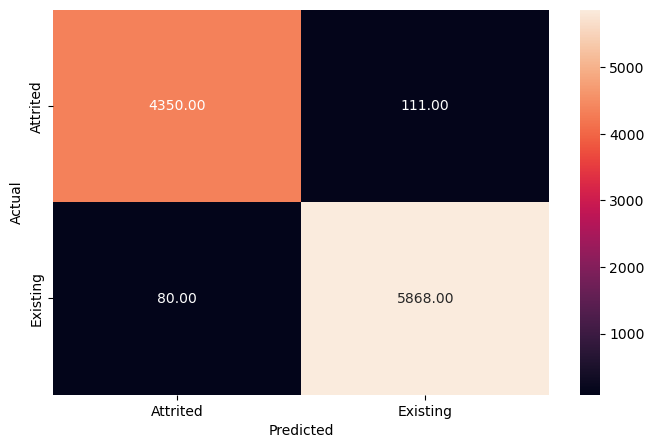

              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       488
         1.0       0.97      0.98      0.98      2551

    accuracy                           0.96      3039
   macro avg       0.94      0.92      0.93      3039
weighted avg       0.96      0.96      0.96      3039



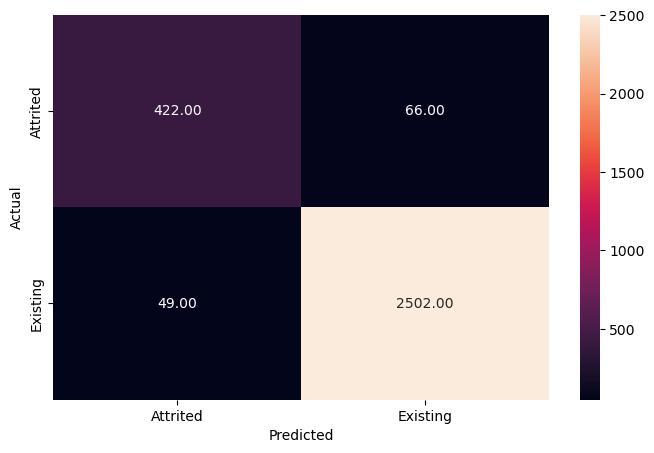

In [84]:
# Evaluate the model
# Checking performance on the training data
metrics_score(y_train_resampled, y_hat_new_lgbm)
metrics_score(y_test, y_pred_new_lgbm)

<Axes: xlabel='Importance'>

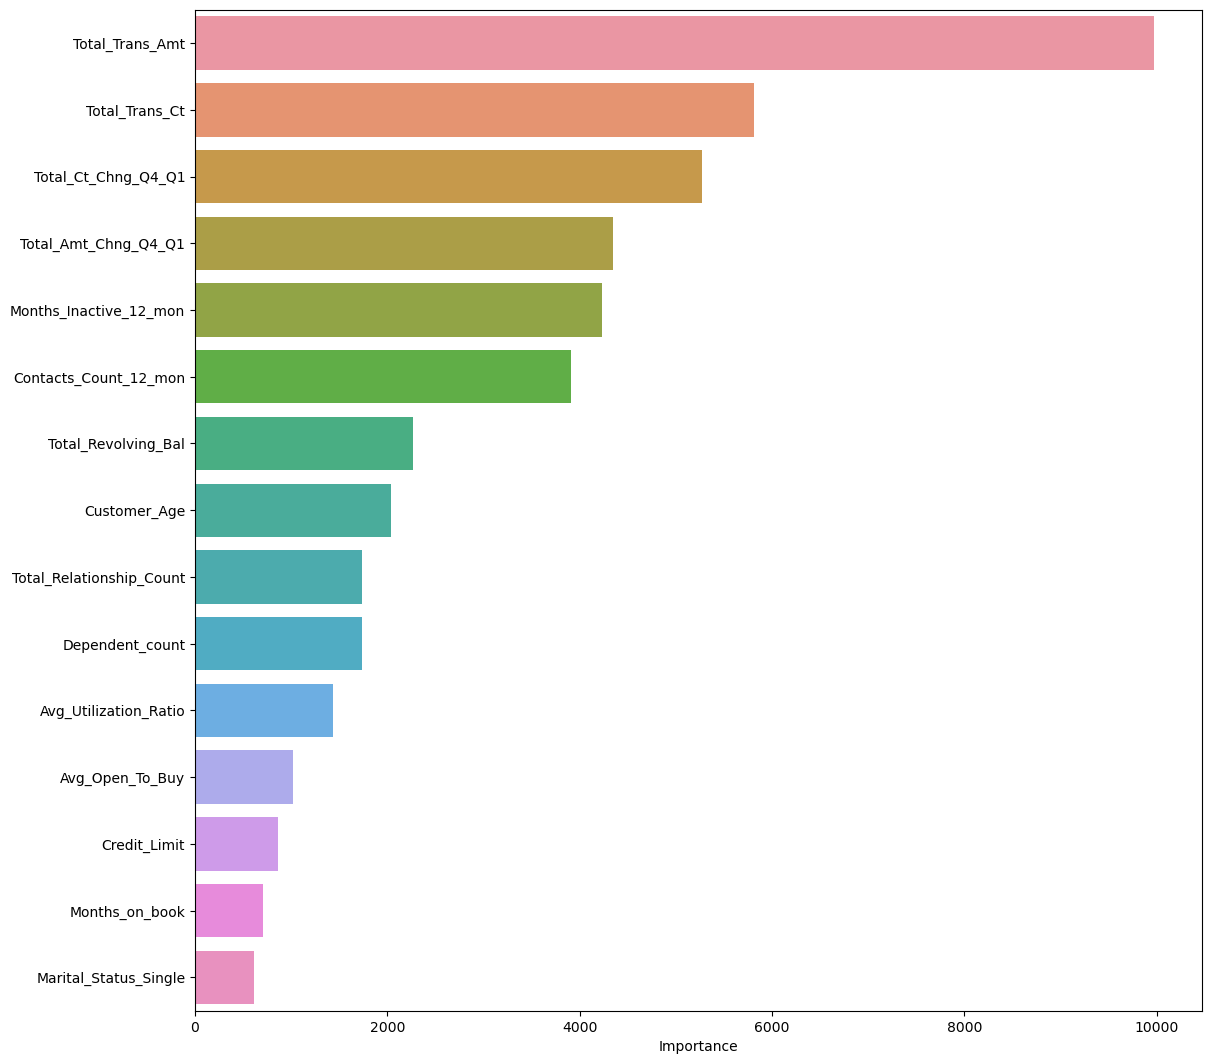

In [85]:
columns = df_train_features.columns

new_lgbm_importance_df = pd.DataFrame(lgb_model.feature_importance(), index = columns, 
                             columns = ['Importance']).sort_values(by = 'Importance', ascending = False).nlargest(15,columns='Importance')

plt.figure(figsize = (13, 13))

sns.barplot(data = new_lgbm_importance_df, x = 'Importance', y = new_lgbm_importance_df.index)

###### Data Observations
- LightGBM has the highest recall percentage, highest precision and highest F1-Score for 'Attried' customers
- This model is the best model to use for this type of prediction
- Though ordered differently, the model still used the same features used in PCA, Random Forest Classifier, Gradient Boost Classifier, and XGBoost.
- Since the model found same features, we can build indicators on the top 15 features with importance levels built in the top 5 or 6 features to watch out for, when finding those bank customers that have the potential to 'Attrite'